# <b> Corporation Favorita Regression Project (Store Sales -- Time Series Forecasting)

### <b> Introduction

Welcome to a compelling journey into the realm of time series forecasting! In this project, we embark on the intriguing challenge of predicting store sales using data from Corporation Favorita, a prominent grocery retailer based in Ecuador. As we delve into the intricacies of this task, our primary objective is to construct a robust model capable of accurately predicting the unit sales for a myriad of items across various Favorita stores.

The foundation of our predictive prowess lies in a diverse array of data points, including dates, store and product details, information about promotional activities, and, crucially, the corresponding sales figures. Our dataset is enriched with supplementary files containing additional information, providing a wealth of insights that can be harnessed to enhance the predictive capabilities of our models.

Join us as we navigate through the nuances of this time series forecasting problem, unraveling patterns, and leveraging comprehensive data to build a model that not only forecasts sales accurately but also unveils the underlying dynamics of retail operations within Corporation Favorita. Your journey begins here, where data science meets the world of retail, promising a captivating exploration of analytics and forecasting.


## **Business Understanding**

### **Objective:** ###

This project aims to develop a robust time series forecasting model to predict store sales for Corporation Favorita, a leading grocery retailer in Ecuador. By leveraging advanced analytics, the goal is to provide accurate predictions for unit sales across a diverse range of items in different Favorita stores. The insights derived from this forecasting model will empower Favorita with data-driven decision-making capabilities, optimizing inventory management, promotional strategies, and overall business performance.

### **Scope:** ###

The project encompasses the exploration and analysis of a comprehensive dataset, including dates, store details, product information, promotional activities, and sales figures. Supplementary files containing additional information will be utilized to enhance the predictive capabilities of the models.

### <b> Business Considerations:
- Supermarket sales could be affected by external factors such as holidays, events, and oil prices.
- Understanding the impact of holidays, events, and oil prices on sales patterns is important for accurate forecasting.
- Seasonality, promotions, and store characteristics (type, location) may also influence sales trends.
- The earthquake in April 2016 had a significant impact on supermarket sales, which needs to be considered in the analysis.


### **Data Field Information:** ###


**1. train.csv:**
Description: The training data, comprising a time series of features including store_nbr, family, onpromotion, and the target variable sales.
Data Fields:
store_nbr: Identifies the store where products are sold.
family: Identifies the type of product sold.
sales: Total sales for a product family at a specific store on a given date.
onpromotion: Total number of items in a product family that were being promoted at a store on a given date.

**2. test.csv:**
Description: The test data, having the same features as the training data. Used to predict target sales for the 15 days after the last date in the training data.
Data Fields:
Same as the train.csv data fields.

**3. transaction.csv:**
Description: Contains information about transactions made on specific dates.
Data Fields:
date: Date of the transaction.
store_nbr: Identifies the store where the transaction occurred.
Additional details about the transaction.

**4. sample_submission.csv:**
Description: A sample submission file in the correct format.

**5. stores.csv:**
Description: Store metadata, including city, state, type, and cluster. Cluster represents a grouping of similar stores.
Data Fields:
store_nbr: Identifies the store.
city: City where the store is located.
state: State where the store is located.
type: Type of the store.
cluster: Grouping of similar stores.


**6. oil.csv:**
Description: Daily oil prices, including values during both the train and test data timeframes. Given Ecuador's dependency on oil, its economical health is highly vulnerable to shocks in oil prices.

**7. holidays_events.csv:**
Description: Holidays and Events metadata, including information about transferred holidays.
Data Fields:
date: Date of the holiday or event.
Additional metadata about the holiday or event.


### **The Hypothesis**

#### Null Hypothesis (H0): There is no significant difference in sales between promoted and non-promoted items.

#### Alternative Hypothesis (H1): Items that are promoted have significantly higher sales compared to non-promoted items.

### **The Analytical Questions**

1. Is the train dataset complete (has all the required dates)?
2. Which dates have the lowest and highest sales for each year?
3. Did the earthquake impact sales?
4. Are certain groups of stores selling more products? (Cluster, city, state, type)?
5. Are sales affected by promotions, oil prices and holidays?
6. What analysis can we get from the date and its extractable features?

## 1. Importing the relevant libraries and modules

In [3]:
import pyodbc
from dotenv import dotenv_values
import re
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings('ignore')

In [4]:
# Visualization
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.patches as mpatches
import seaborn as sns
import plotly.express as px


# Statistical Analysis
from statsmodels.tsa.stattools import adfuller
from scipy.stats import ttest_ind
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_squared_log_error


# Feature Processing
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler

# Modelling
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.model_selection import RandomizedSearchCV
import pickle

In [5]:
# Load environment variables from .env file into a dictionary
environment_variables = dotenv_values('.env')

In [6]:
# Get the values for the credentials you set in the '.env' file
server = environment_variables.get("server")
database = environment_variables.get("database")
username = environment_variables.get("username")
password = environment_variables.get("password")


# Construct the connection string
connection_string = f"DRIVER={{SQL Server}};SERVER={server};DATABASE={database};UID={username};PWD={password};MARS_Connection=yes;MinProtocolVersion=TLSv1.2;"

In [7]:
# Establish a connection to the database using the provided connection string.
connection= pyodbc.connect(connection_string)

## 2. Loading data

In [8]:
# SQL query to fetch data from 'dbo.oil' table
query = "Select * from dbo.oil"

 
# Read data from the SQL query result
df_oil = pd.read_sql(query, connection)
 
 # Display the first few rows of the DataFrame
df_oil.head()

,date,dcoilwtico
0,2013-01-01,NaN
1,2013-01-02,93.139999
2,2013-01-03,92.970001
3,2013-01-04,93.120003
4,2013-01-07,93.199997


In [9]:
df_oil.shape

(1218, 2)

In [10]:
df_oil.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1218 entries, 0 to 1217
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   date        1218 non-null   object 
 1   dcoilwtico  1175 non-null   float64
dtypes: float64(1), object(1)
memory usage: 19.2+ KB


The DataFrame contains 1218 entries. While the 'date' column has no missing values, the 'dcoilwtico' column contains 43 missing values out of the total entries, indicating incomplete data.

In [11]:
#Saving the oil dataset
df_oil.to_csv("df_oil.csv")

In [12]:

# SQL query to fetch data from 'dbo.holidays_events' table
query = "Select * from dbo.holidays_events"

# Read data from the SQL query result
df_holidays_events = pd.read_sql(query, connection)
 # Display the first few rows of the DataFrame
df_holidays_events.head()

,date,type,locale,locale_name,description,transferred
0,2012-03-02,Holiday,Local,Manta,Fundacion de Manta,False
1,2012-04-01,Holiday,Regional,Cotopaxi,Provincializacion de Cotopaxi,False
2,2012-04-12,Holiday,Local,Cuenca,Fundacion de Cuenca,False
3,2012-04-14,Holiday,Local,Libertad,Cantonizacion de Libertad,False
4,2012-04-21,Holiday,Local,Riobamba,Cantonizacion de Riobamba,False


In [13]:
df_holidays_events.shape

(350, 6)

In [14]:
df_holidays_events.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 350 entries, 0 to 349
Data columns (total 6 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   date         350 non-null    object
 1   type         350 non-null    object
 2   locale       350 non-null    object
 3   locale_name  350 non-null    object
 4   description  350 non-null    object
 5   transferred  350 non-null    bool  
dtypes: bool(1), object(5)
memory usage: 14.1+ KB


In [15]:
#Saving holiday events dataset
df_holidays_events.to_csv("df_holiday_events")

In [16]:
# SQL query to fetch data from 'dbo_stores' table
query = "Select * from dbo.stores"

 
# Read data from the SQL query result
df_stores = pd.read_sql(query, connection)
 
 # Display the first few rows of the DataFrame
df_stores.head()

,store_nbr,city,state,type,cluster
0,1,Quito,Pichincha,D,13
1,2,Quito,Pichincha,D,13
2,3,Quito,Pichincha,D,8
3,4,Quito,Pichincha,D,9
4,5,Santo Domingo,Santo Domingo de los Tsachilas,D,4


In [17]:
df_stores.shape

(54, 5)

In [18]:
df_stores.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 54 entries, 0 to 53
Data columns (total 5 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   store_nbr  54 non-null     int64 
 1   city       54 non-null     object
 2   state      54 non-null     object
 3   type       54 non-null     object
 4   cluster    54 non-null     int64 
dtypes: int64(2), object(3)
memory usage: 2.2+ KB


In [19]:
#Saving the stores data
df_stores.to_csv("df_stores.csv")

In [20]:
# Reading Data from Onedrive

file_path = r'C:\Users\HP\Desktop\LP3 REGRESSION PROJECT\LP-3-Regression-Project\data\sample_submission.csv'

df_submission = pd.read_csv(file_path)
   

In [21]:
df_submission.head()

,id,sales
0,3000888,0.0
1,3000889,0.0
2,3000890,0.0
3,3000891,0.0
4,3000892,0.0


In [22]:
file_path = r'C:\Users\HP\Desktop\LP3 REGRESSION PROJECT\LP-3-Regression-Project\data\test.csv'

df_test  = pd.read_csv(file_path)

In [23]:
df_test.head()

,id,date,store_nbr,family,onpromotion
0,3000888,2017-08-16,1,AUTOMOTIVE,0
1,3000889,2017-08-16,1,BABY CARE,0
2,3000890,2017-08-16,1,BEAUTY,2
3,3000891,2017-08-16,1,BEVERAGES,20
4,3000892,2017-08-16,1,BOOKS,0


In [24]:
df_test.shape

(28512, 5)

In [25]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 28512 entries, 0 to 28511
Data columns (total 5 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   id           28512 non-null  int64 
 1   date         28512 non-null  object
 2   store_nbr    28512 non-null  int64 
 3   family       28512 non-null  object
 4   onpromotion  28512 non-null  int64 
dtypes: int64(3), object(2)
memory usage: 1.1+ MB


In [26]:
# Reading Data from Github
file_path = r'C:\Users\HP\Desktop\LP3 REGRESSION PROJECT\LP-3-Regression-Project\data\train.csv'

df_train = pd.read_csv(file_path)

In [27]:
df_train.head()

,id,date,store_nbr,family,sales,onpromotion
0,0,2013-01-01,1,AUTOMOTIVE,0.0,0
1,1,2013-01-01,1,BABY CARE,0.0,0
2,2,2013-01-01,1,BEAUTY,0.0,0
3,3,2013-01-01,1,BEVERAGES,0.0,0
4,4,2013-01-01,1,BOOKS,0.0,0


In [28]:
df_train.shape

(3000888, 6)

In [29]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3000888 entries, 0 to 3000887
Data columns (total 6 columns):
 #   Column       Dtype  
---  ------       -----  
 0   id           int64  
 1   date         object 
 2   store_nbr    int64  
 3   family       object 
 4   sales        float64
 5   onpromotion  int64  
dtypes: float64(1), int64(3), object(2)
memory usage: 137.4+ MB


In [30]:
file_path = r'C:\Users\HP\Desktop\LP3 REGRESSION PROJECT\LP-3-Regression-Project\data\transactions.csv'

df_transaction = pd.read_csv(file_path)

In [31]:
df_transaction.head()

,date,store_nbr,transactions
0,2013-01-01,25,770
1,2013-01-02,1,2111
2,2013-01-02,2,2358
3,2013-01-02,3,3487
4,2013-01-02,4,1922


In [32]:
df_transaction.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 83488 entries, 0 to 83487
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   date          83488 non-null  object
 1   store_nbr     83488 non-null  int64 
 2   transactions  83488 non-null  int64 
dtypes: int64(2), object(1)
memory usage: 1.9+ MB


## <b> Data Understanding

In [33]:
# Checking for the summary statistics of the datasets 
datasets = {'train': df_train, 'test': df_test, 'holiday events': df_holidays_events, 'oil': df_oil, 'stores':df_stores, 'transactions': df_transaction}
for name, data in datasets.items():
    print(f"{name.capitalize()} dataset summary statistics:")
    print('---'*15)
    print(data.describe())
    print('==='*20)
    print()

Train dataset summary statistics:
---------------------------------------------
                 id     store_nbr         sales   onpromotion
count  3.000888e+06  3.000888e+06  3.000888e+06  3.000888e+06
mean   1.500444e+06  2.750000e+01  3.577757e+02  2.602770e+00
std    8.662819e+05  1.558579e+01  1.101998e+03  1.221888e+01
min    0.000000e+00  1.000000e+00  0.000000e+00  0.000000e+00
25%    7.502218e+05  1.400000e+01  0.000000e+00  0.000000e+00
50%    1.500444e+06  2.750000e+01  1.100000e+01  0.000000e+00
75%    2.250665e+06  4.100000e+01  1.958473e+02  0.000000e+00
max    3.000887e+06  5.400000e+01  1.247170e+05  7.410000e+02

Test dataset summary statistics:
---------------------------------------------
                 id     store_nbr   onpromotion
count  2.851200e+04  28512.000000  28512.000000
mean   3.015144e+06     27.500000      6.965383
std    8.230850e+03     15.586057     20.683952
min    3.000888e+06      1.000000      0.000000
25%    3.008016e+06     14.000000      0.0

#### Train Dataset Summary Statistics:
- Sales range from 0 to 124,717, with a mean of 358 and a standard deviation of 1,102.
- Most sales are not on promotion, but the maximum promotion value is 741.

#### Test Dataset Summary Statistics:
- Sales data are not available in the test dataset.
- Promotion values range from 0 to 646, with a mean of 7 and a standard deviation of 21.

#### Holiday Events Dataset Summary Statistics:
- There are 350 holiday events, with 312 unique dates and 103 unique descriptions.
- Most events are not transferred, and the most common holiday is Carnaval.

#### Oil Dataset Summary Statistics:
- Daily oil prices range from 26.19 to 110.62, with a mean of 67.71 and a standard deviation of 25.63.

#### Stores Dataset Summary Statistics:
- There are 54 stores with cluster values ranging from 1 to 17.
- The mean cluster value is 8.48.

#### Transactions Dataset Summary Statistics:
- Transactions range from 5 to 8,359, with a mean of 1,695 and a standard deviation of 963.
- Most transactions occur at store number 27, and the mean number of transactions is 1,695.


In [34]:
# Check for missing values in the datasets
datasets = {'train': df_train, 'test': df_test, 'holiday events': df_holidays_events, 'oil': df_oil, 'stores': df_stores, 'transactions': df_transaction, }

def show_missing_values(datasets):
    for name, data in datasets.items():
        print(f"Missing values in the {name.capitalize()} dataset:")
        print(data.isnull().sum())
        print('===' * 18)
        print()

show_missing_values(datasets)

Missing values in the Train dataset:
id             0
date           0
store_nbr      0
family         0
sales          0
onpromotion    0
dtype: int64

Missing values in the Test dataset:
id             0
date           0
store_nbr      0
family         0
onpromotion    0
dtype: int64

Missing values in the Holiday events dataset:
date           0
type           0
locale         0
locale_name    0
description    0
transferred    0
dtype: int64

Missing values in the Oil dataset:
date           0
dcoilwtico    43
dtype: int64

Missing values in the Stores dataset:
store_nbr    0
city         0
state        0
type         0
cluster      0
dtype: int64

Missing values in the Transactions dataset:
date            0
store_nbr       0
transactions    0
dtype: int64



The main observation is that missing values are present only in the 'dcoilwtico' column of the Oil dataset. There are 43 missing values. All other datasets are complete in terms of missing values. 

In [35]:
# dataset columns data types
datasets = {
    'train': df_train,
    'test': df_test,
    'holiday events': df_holidays_events,
    'oil': df_oil,
    'stores': df_stores,
    'transactions': df_transaction
}

for name, dataset in datasets.items():
    print(f"Data types in {name} dataset:")
    print(dataset.dtypes)
    print("=" * 50)


Data types in train dataset:
id               int64
date            object
store_nbr        int64
family          object
sales          float64
onpromotion      int64
dtype: object
Data types in test dataset:
id              int64
date           object
store_nbr       int64
family         object
onpromotion     int64
dtype: object
Data types in holiday events dataset:
date           object
type           object
locale         object
locale_name    object
description    object
transferred      bool
dtype: object
Data types in oil dataset:
date           object
dcoilwtico    float64
dtype: object
Data types in stores dataset:
store_nbr     int64
city         object
state        object
type         object
cluster       int64
dtype: object
Data types in transactions dataset:
date            object
store_nbr        int64
transactions     int64
dtype: object


Suggestions for Changes:

Convert Date Columns: For datasets with a 'date' column (e.g., Train, Test, Holiday Events, Oil, Transactions), consider converting the 'date' column to datetime objects using pd.to_datetime() to facilitate date-based operations and analysis.

## <b> Data Preprocessing

### Transforming the 'date' column to datetime format

In [36]:
# Converting the 'date' column in the datasets to datetime format
# Train dataset
df_train['date'] = pd.to_datetime(df_train['date'])

# Test dataset
df_test['date'] = pd.to_datetime(df_test['date'])

# Holiday Events dataset
df_holidays_events['date'] = pd.to_datetime(df_holidays_events['date'])

# Oil dataset
df_oil['date'] = pd.to_datetime(df_oil['date'])

# Transactions dataset
df_transaction['date'] = pd.to_datetime(df_transaction['date'])

In [37]:
# Confirm the data type of the 'date' column after transformation
print('Date Column Data Type After Transformation:') 
print('==='*14)
print("Train dataset:", df_train['date'].dtype)
print("Test dataset:", df_test['date'].dtype)
print("Holiday Events dataset:", df_holidays_events['date'].dtype)
print("Oil dataset:", df_oil['date'].dtype)
print("Transactions dataset:", df_transaction['date'].dtype)

Date Column Data Type After Transformation:
Train dataset: datetime64[ns]
Test dataset: datetime64[ns]
Holiday Events dataset: datetime64[ns]
Oil dataset: datetime64[ns]
Transactions dataset: datetime64[ns]


##### Data Preprocessing  on train dataset

In [38]:
df_train.head()

,id,date,store_nbr,family,sales,onpromotion
0,0,2013-01-01,1,AUTOMOTIVE,0.0,0
1,1,2013-01-01,1,BABY CARE,0.0,0
2,2,2013-01-01,1,BEAUTY,0.0,0
3,3,2013-01-01,1,BEVERAGES,0.0,0
4,4,2013-01-01,1,BOOKS,0.0,0


In [39]:
df_train.isna().sum()

id             0
date           0
store_nbr      0
family         0
sales          0
onpromotion    0
dtype: int64

In [40]:
#drop the unnecessary column
df_train.drop('id',axis=1,inplace=True)

In [41]:
#Checking for duplicates
df_train.duplicated().sum()

0

##### Checking for the completeness of the dates in the train dataset

In [42]:
#Checking for the minimum date
df_train['date'].min()

Timestamp('2013-01-01 00:00:00')

The train dataset is as from January first, 2013

In [43]:
#The maximum date 
df_train['date'].max()

Timestamp('2017-08-15 00:00:00')

The train data ends in August 15, 2017, at midnight (00:00:00).

In [44]:
# Convert the 'date' column to datetime dtype
df_train['date'] = pd.to_datetime(df_train['date'])

# Now you can access datetime properties and methods using .dt accessor
df_train['date'] = df_train['date'].dt.date


In [45]:
#Checking for the range of the dates column
dates_range = pd.date_range(start=df_train['date'].min(),end=df_train['date'].max())
dates_range

DatetimeIndex(['2013-01-01', '2013-01-02', '2013-01-03', '2013-01-04',
               '2013-01-05', '2013-01-06', '2013-01-07', '2013-01-08',
               '2013-01-09', '2013-01-10',
               ...
               '2017-08-06', '2017-08-07', '2017-08-08', '2017-08-09',
               '2017-08-10', '2017-08-11', '2017-08-12', '2017-08-13',
               '2017-08-14', '2017-08-15'],
              dtype='datetime64[ns]', length=1688, freq='D')

In [46]:
#Checking for the missing dates
dates_missing = set(dates_range.date) - set(df_train['date'].unique())


# Calculate the missing dates
#dates_missing = list(set(dates_range.date) - set(df_train['date'].dt.date.unique()))
dates_missing

{datetime.date(2013, 12, 25),
 datetime.date(2014, 12, 25),
 datetime.date(2015, 12, 25),
 datetime.date(2016, 12, 25)}

In [47]:
# Convert dates_missing set to a list
dates_missing_list = list(dates_missing)

# Create a DataFrame with the missing dates using the 'date' column
missing_data = pd.DataFrame({'date': dates_missing_list})

# Concatenate the original train dataset and the missing data DataFrame
# ignore_index=True ensures a new index is assigned to the resulting DataFrame
train_merged = pd.concat([df_train, missing_data], ignore_index=True)

# Sort the DataFrame based on the 'date' column in ascending order
train_merged.sort_values('date', inplace=True)


. Creating a new DataFrame with the values in the date range, as shown in the code snippet provided above , serves in Interpolation and Filling Missing Values: You can use this new DataFrame to perform interpolation or fill missing values for dates that are not present in your original dataset but fall within the specified date range. This is useful for ensuring continuity and smoothness in time series data.



In [48]:
train_merged.isna().sum()

date           0
store_nbr      4
family         4
sales          4
onpromotion    4
dtype: int64

In [49]:
# Fill missing values using backfill method
train_merged_interpolated = train_merged.fillna(method='bfill')

# Check if there are any missing values after filling
missing_values_count = train_merged_interpolated.isnull().sum()
print(missing_values_count)


date           0
store_nbr      0
family         0
sales          0
onpromotion    0
dtype: int64


. To preserve the temporal order of the data, the imputation used is backwardfill. Interpolation in Python is a technique used to estimate unknown data points between two known data points. Backward fill is an approach where missing values are filled with the next available observation in the dataset (Agrawal, 2022).By filling missing values with the next available observation, the imputed values maintain the temporal sequence of the data.

In [50]:
train_merged_interpolated.duplicated().sum()

0

In [51]:
train_merged_interpolated.info()

<class 'pandas.core.frame.DataFrame'>
Index: 3000892 entries, 0 to 2999554
Data columns (total 5 columns):
 #   Column       Dtype  
---  ------       -----  
 0   date         object 
 1   store_nbr    float64
 2   family       object 
 3   sales        float64
 4   onpromotion  float64
dtypes: float64(3), object(2)
memory usage: 137.4+ MB


In [52]:
# Convert 'date' column to datetime type 
train_merged_interpolated['date'] = pd.to_datetime(df_train['date'])

In [53]:
train_merged_interpolated.head()

,date,store_nbr,family,sales,onpromotion
0,2013-01-01,1.0,AUTOMOTIVE,0.0,0.0
1194,2013-01-01,42.0,CELEBRATION,0.0,0.0
1193,2013-01-01,42.0,BREAD/BAKERY,0.0,0.0
1192,2013-01-01,42.0,BOOKS,0.0,0.0
1191,2013-01-01,42.0,BEVERAGES,0.0,0.0


#### Oil dataset Processing and Preparation

In [54]:
df_oil.head()

,date,dcoilwtico
0,2013-01-01,NaN
1,2013-01-02,93.139999
2,2013-01-03,92.970001
3,2013-01-04,93.120003
4,2013-01-07,93.199997


In [55]:
df_oil.isna().sum()

date           0
dcoilwtico    43
dtype: int64

In [56]:
# Visualizing the 'dcoilwtico' column to Identify a Strategy for Handling Missing Values
fig = px.line(df_oil, x='date', y='dcoilwtico')
fig.update_layout(title='Trend of Oil Prices Over Time', title_x=0.5, xaxis_title='Date', yaxis_title='Oil Price')
fig.update_xaxes(rangeslider_visible=True)
fig.show()

In [57]:
# use missing values with backfill
df_oil = pd.DataFrame(df_oil)
df_oil = df_oil.bfill()

In [58]:
# Visualizing the 'dcoilwtico' after filling with backfill
fig = px.line(df_oil, x='date', y='dcoilwtico')
fig.update_layout(title='Trend of Oil Prices Over Time', title_x=0.5, xaxis_title='Date', yaxis_title='Oil Price')
fig.update_xaxes(rangeslider_visible=True)
fig.show()

In [59]:
df_oil.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1218 entries, 0 to 1217
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   date        1218 non-null   datetime64[ns]
 1   dcoilwtico  1218 non-null   float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 19.2 KB


In [60]:
df_oil.isna().sum()

date          0
dcoilwtico    0
dtype: int64

### Merging The Train Dataset with the Stores, Transactions, Holiday Events and Oil Dataset

In [61]:
df_transaction.head()

,date,store_nbr,transactions
0,2013-01-01,25,770
1,2013-01-02,1,2111
2,2013-01-02,2,2358
3,2013-01-02,3,3487
4,2013-01-02,4,1922


In [62]:
df_transaction.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 83488 entries, 0 to 83487
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   date          83488 non-null  datetime64[ns]
 1   store_nbr     83488 non-null  int64         
 2   transactions  83488 non-null  int64         
dtypes: datetime64[ns](1), int64(2)
memory usage: 1.9 MB


In [63]:
df_oil.head()

,date,dcoilwtico
0,2013-01-01,93.139999
1,2013-01-02,93.139999
2,2013-01-03,92.970001
3,2013-01-04,93.120003
4,2013-01-07,93.199997


In [64]:
df_oil.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1218 entries, 0 to 1217
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   date        1218 non-null   datetime64[ns]
 1   dcoilwtico  1218 non-null   float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 19.2 KB


In [65]:
df_holidays_events.head()

,date,type,locale,locale_name,description,transferred
0,2012-03-02,Holiday,Local,Manta,Fundacion de Manta,False
1,2012-04-01,Holiday,Regional,Cotopaxi,Provincializacion de Cotopaxi,False
2,2012-04-12,Holiday,Local,Cuenca,Fundacion de Cuenca,False
3,2012-04-14,Holiday,Local,Libertad,Cantonizacion de Libertad,False
4,2012-04-21,Holiday,Local,Riobamba,Cantonizacion de Riobamba,False


In [66]:
df_holidays_events.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 350 entries, 0 to 349
Data columns (total 6 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   date         350 non-null    datetime64[ns]
 1   type         350 non-null    object        
 2   locale       350 non-null    object        
 3   locale_name  350 non-null    object        
 4   description  350 non-null    object        
 5   transferred  350 non-null    bool          
dtypes: bool(1), datetime64[ns](1), object(4)
memory usage: 14.1+ KB


In [67]:
df_stores.head()

,store_nbr,city,state,type,cluster
0,1,Quito,Pichincha,D,13
1,2,Quito,Pichincha,D,13
2,3,Quito,Pichincha,D,8
3,4,Quito,Pichincha,D,9
4,5,Santo Domingo,Santo Domingo de los Tsachilas,D,4


In [68]:



# Merging df_train with df_stores based on 'store_nbr' column
merged_data = pd.merge(train_merged_interpolated, df_stores, on='store_nbr', how='inner')

# Merging merged_data with df_transaction based on 'date' and 'store_nbr' columns
merged_data = pd.merge(merged_data, df_transaction, on=['date', 'store_nbr'], how='inner')

# Merging merged_data with df_holidays_events based on 'date' column
merged_data = pd.merge(merged_data, df_holidays_events, on='date', how='inner')

# Merging merged_data with df_oil based on 'date' column
merged_data = pd.merge(merged_data, df_oil, on='date', how='inner')


# Display the first few rows of the merged DataFrame
merged_data.head()




,date,store_nbr,family,sales,onpromotion,city,state,type_x,cluster,transactions,type_y,locale,locale_name,description,transferred,dcoilwtico
0,2013-02-11,1.0,AUTOMOTIVE,0.0,0.0,Quito,Pichincha,D,13,396,Holiday,National,Ecuador,Carnaval,False,97.010002
1,2013-02-11,1.0,MAGAZINES,0.0,0.0,Quito,Pichincha,D,13,396,Holiday,National,Ecuador,Carnaval,False,97.010002
2,2013-02-11,1.0,"LIQUOR,WINE,BEER",21.0,0.0,Quito,Pichincha,D,13,396,Holiday,National,Ecuador,Carnaval,False,97.010002
3,2013-02-11,1.0,LINGERIE,0.0,0.0,Quito,Pichincha,D,13,396,Holiday,National,Ecuador,Carnaval,False,97.010002
4,2013-02-11,1.0,LAWN AND GARDEN,3.0,0.0,Quito,Pichincha,D,13,396,Holiday,National,Ecuador,Carnaval,False,97.010002


In [69]:
merged_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 322047 entries, 0 to 322046
Data columns (total 16 columns):
 #   Column        Non-Null Count   Dtype         
---  ------        --------------   -----         
 0   date          322047 non-null  datetime64[ns]
 1   store_nbr     322047 non-null  float64       
 2   family        322047 non-null  object        
 3   sales         322047 non-null  float64       
 4   onpromotion   322047 non-null  float64       
 5   city          322047 non-null  object        
 6   state         322047 non-null  object        
 7   type_x        322047 non-null  object        
 8   cluster       322047 non-null  int64         
 9   transactions  322047 non-null  int64         
 10  type_y        322047 non-null  object        
 11  locale        322047 non-null  object        
 12  locale_name   322047 non-null  object        
 13  description   322047 non-null  object        
 14  transferred   322047 non-null  bool          
 15  dcoilwtico    322

In [70]:
# Renaming the columns with the approapriate names
merged_data = merged_data.rename(columns={"type_x": "store_type", "type_y": "holiday_type"})
merged_data.head()

,date,store_nbr,family,sales,onpromotion,city,state,store_type,cluster,transactions,holiday_type,locale,locale_name,description,transferred,dcoilwtico
0,2013-02-11,1.0,AUTOMOTIVE,0.0,0.0,Quito,Pichincha,D,13,396,Holiday,National,Ecuador,Carnaval,False,97.010002
1,2013-02-11,1.0,MAGAZINES,0.0,0.0,Quito,Pichincha,D,13,396,Holiday,National,Ecuador,Carnaval,False,97.010002
2,2013-02-11,1.0,"LIQUOR,WINE,BEER",21.0,0.0,Quito,Pichincha,D,13,396,Holiday,National,Ecuador,Carnaval,False,97.010002
3,2013-02-11,1.0,LINGERIE,0.0,0.0,Quito,Pichincha,D,13,396,Holiday,National,Ecuador,Carnaval,False,97.010002
4,2013-02-11,1.0,LAWN AND GARDEN,3.0,0.0,Quito,Pichincha,D,13,396,Holiday,National,Ecuador,Carnaval,False,97.010002


In [71]:
merged_data.isna().sum()

date            0
store_nbr       0
family          0
sales           0
onpromotion     0
city            0
state           0
store_type      0
cluster         0
transactions    0
holiday_type    0
locale          0
locale_name     0
description     0
transferred     0
dcoilwtico      0
dtype: int64

In [72]:
# Sort the DataFrame by the 'date' column
merged_data = merged_data.sort_values('date')




In [73]:
# Fill missing values in the 'dcoilwtico' column using backfill method
merged_data['dcoilwtico'] = merged_data['dcoilwtico'].fillna(method='bfill')

# Check if there are any remaining missing values
merged_data.isnull().sum()

date            0
store_nbr       0
family          0
sales           0
onpromotion     0
city            0
state           0
store_type      0
cluster         0
transactions    0
holiday_type    0
locale          0
locale_name     0
description     0
transferred     0
dcoilwtico      0
dtype: int64

In [74]:
# Check for duplicate values in the merged dataset
duplicate_rows_merged = merged_data.duplicated()
duplicate_rows_merged.sum()

0

In [75]:
# Check for duplicate values in the test dataset
duplicate_rows_test = df_test.duplicated()
duplicate_rows_test.sum()

0

#### Save the merged dataset in a new CSV file to be used in PowerBI Visualization

In [76]:
merged_data.to_csv('Data/Visualization_Data.csv', index=False)
merged_data.head()

,date,store_nbr,family,sales,onpromotion,city,state,store_type,cluster,transactions,holiday_type,locale,locale_name,description,transferred,dcoilwtico
322007,2013-01-01,25.0,SCHOOL AND OFFICE SUPPLIES,0.000,0.0,Salinas,Santa Elena,D,1,770,Holiday,National,Ecuador,Primer dia del ano,False,93.139999
322013,2013-01-01,25.0,PERSONAL CARE,25.000,0.0,Salinas,Santa Elena,D,1,770,Holiday,National,Ecuador,Primer dia del ano,False,93.139999
322012,2013-01-01,25.0,PET SUPPLIES,0.000,0.0,Salinas,Santa Elena,D,1,770,Holiday,National,Ecuador,Primer dia del ano,False,93.139999
322011,2013-01-01,25.0,PLAYERS AND ELECTRONICS,0.000,0.0,Salinas,Santa Elena,D,1,770,Holiday,National,Ecuador,Primer dia del ano,False,93.139999
322010,2013-01-01,25.0,POULTRY,42.637,0.0,Salinas,Santa Elena,D,1,770,Holiday,National,Ecuador,Primer dia del ano,False,93.139999


In [77]:
# Create A Copy of The Merged Dataset
merged_df_copy = merged_data.copy()
merged_df_copy.info()

<class 'pandas.core.frame.DataFrame'>
Index: 322047 entries, 322007 to 320677
Data columns (total 16 columns):
 #   Column        Non-Null Count   Dtype         
---  ------        --------------   -----         
 0   date          322047 non-null  datetime64[ns]
 1   store_nbr     322047 non-null  float64       
 2   family        322047 non-null  object        
 3   sales         322047 non-null  float64       
 4   onpromotion   322047 non-null  float64       
 5   city          322047 non-null  object        
 6   state         322047 non-null  object        
 7   store_type    322047 non-null  object        
 8   cluster       322047 non-null  int64         
 9   transactions  322047 non-null  int64         
 10  holiday_type  322047 non-null  object        
 11  locale        322047 non-null  object        
 12  locale_name   322047 non-null  object        
 13  description   322047 non-null  object        
 14  transferred   322047 non-null  bool          
 15  dcoilwtico    322

In [78]:
#Basic statistics of the merged dataset
merged_data.describe().T

,count,mean,min,25%,50%,75%,max,std
date,322047,2015-08-04 23:49:57.971104,2013-01-01 00:00:00,2014-07-23 00:00:00,2015-11-02 00:00:00,2016-05-27 00:00:00,2017-08-15 00:00:00,NaN
store_nbr,322047.0,26.994672,1.0,13.0,27.0,40.0,54.0,15.595174
sales,322047.0,406.383452,0.0,1.0,19.0,241.260505,124717.0,1246.88124
onpromotion,322047.0,3.727136,0.0,0.0,0.0,1.0,716.0,15.512095
cluster,322047.0,8.531202,1.0,4.0,9.0,13.0,17.0,4.713809
transactions,322047.0,1734.11784,54.0,1030.0,1409.0,2148.0,8359.0,1050.335018
dcoilwtico,322047.0,63.636381,27.959999,44.880001,51.98,94.089996,107.949997,24.855753


### Summary Statistics of the Dataset

### Interpretation:

- **Date**: There are 322,047 observations. The date ranges from January 1, 2013, to August 15, 2017. The mean date is August 4, 2015.
- **Store Number**: The average store number is approximately 26.99. The store numbers range from 1 to 54.
- **Sales**: The average sales amount is approximately 406.38 units. Sales range from 0 to 124,717 units. The distribution is right-skewed, as the mean is greater than the median.
- **On Promotion**: The average promotion indicator value is approximately 3.73. This variable seems to represent a categorical variable indicating whether an item is on promotion.
- **Cluster**: The average cluster number is approximately 8.53. Cluster numbers range from 1 to 17.
- **Transactions**: The average number of transactions is approximately 1734.12. Transactions range from 54 to 8359.
- **Dcoilwtico**: The average oil price is approximately 63.58. Oil prices range from 27.96 to 107.95.

These statistics provide insights into the central tendency, dispersion, and distribution of each variable in the dataset.


## Univariate, Bivariate Analysis and Multivariate Analysis

#### Univariate Analysis

count                        322047
mean     2015-08-04 23:49:57.971104
min             2013-01-01 00:00:00
25%             2014-07-23 00:00:00
50%             2015-11-02 00:00:00
75%             2016-05-27 00:00:00
max             2017-08-15 00:00:00
Name: date, dtype: object


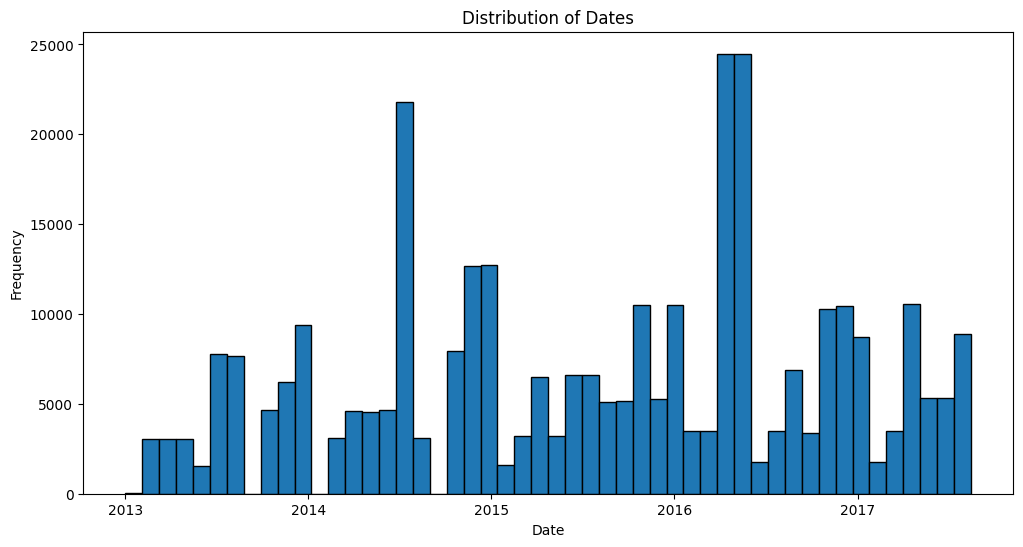

In [79]:
# Check basic information about the 'date' column
print(merged_data['date'].describe())

# Plot the distribution of dates
merged_data['date'].hist(bins=50, edgecolor='black', figsize=(12, 6), grid=False)
plt.title('Distribution of Dates')
plt.xlabel('Date')
plt.ylabel('Frequency')
plt.show()


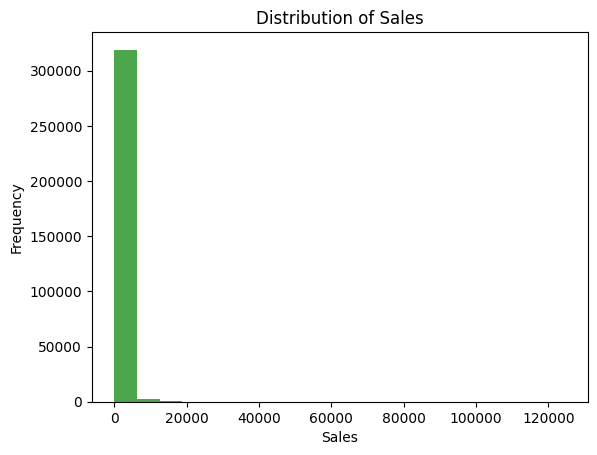

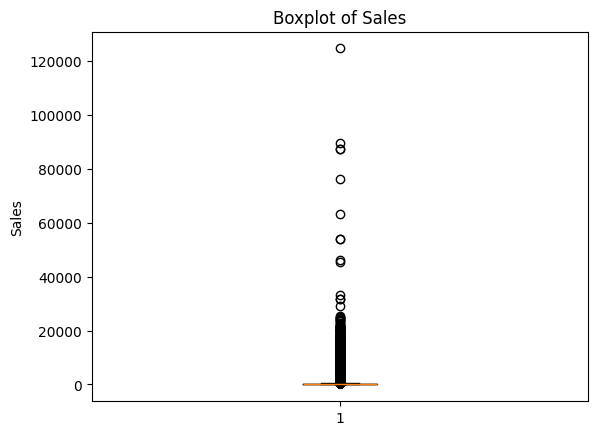

In [80]:
# Histogram
plt.hist(merged_data['sales'], bins=20, color='green', alpha=0.7 )
plt.xlabel('Sales')
plt.ylabel('Frequency')
plt.title('Distribution of Sales')
plt.grid(False)
plt.show()

# Boxplot
plt.boxplot(merged_data['sales'] )
plt.ylabel('Sales')
plt.title('Boxplot of Sales')
plt.grid(False)
plt.show()


### Summary of Histogram and Boxplot Analysis

### Histogram Analysis:
- The histogram visually displays the frequency distribution of sales values, indicating the concentration of sales within specific ranges.
- A prominent peak in the histogram signifies the most common sales values or a narrow range where sales are concentrated.
- The right-skewed distribution suggests that while most sales fall within the central range, there are also instances of significantly higher sales values.

### Boxplot Analysis:
- Outliers, depicted as data points beyond the whiskers, highlight exceptional sales performances or unexpected events.
- Quartiles represented by the box offer insights into the spread of the data and delineate the lower and upper halves of the sales distribution.

### Combined Insights:
- The majority of sales cluster around the peak in the histogram, reflecting typical sales performance and expected revenue ranges.
- The presence of outliers and the right skew in the distribution indicate variability in sales data, with occasional instances of significantly higher sales.
- Analyzing outliers can uncover trends, customer segments, or product variations contributing to notable sales deviations.

In summary, the combined analysis of the histogram and boxplot provides a comprehensive understanding of sales distribution, highlighting central tendencies, skewness, and outlier presence. These insights inform strategic decision-making, pricing optimization, and customer behavior understanding within the business context.


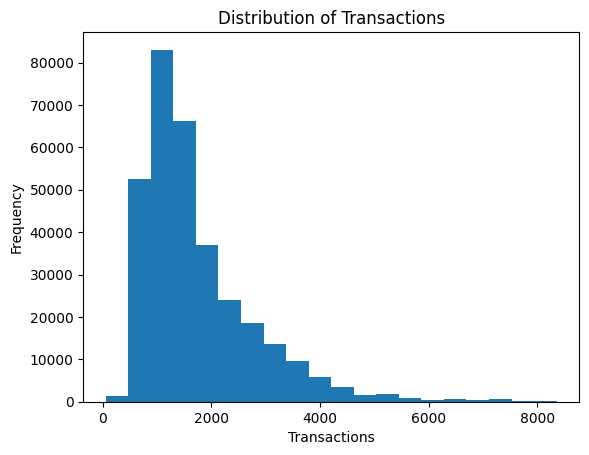

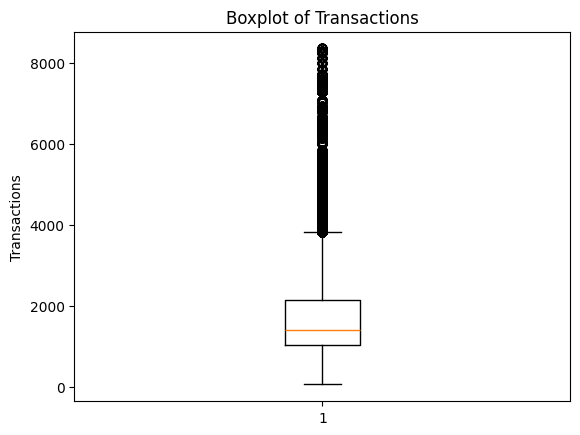

In [81]:
# Histogram
plt.hist(merged_data['transactions'], bins=20)
plt.xlabel('Transactions')
plt.ylabel('Frequency')
plt.title('Distribution of Transactions')
plt.grid(False)
plt.show()

# Boxplot
plt.boxplot(merged_data['transactions'])
plt.ylabel('Transactions')
plt.title('Boxplot of Transactions')
plt.grid(False)
plt.show()

### Key Insights from the Transaction Distribution Histogram:

Majority of Transactions Concentrated in a Specific Range:

The histogram's peak on the left side demonstrates that a significant proportion of transactions fall within a relatively narrow range.
This suggests that these transaction volumes are the most common or typical within the dataset.
Right-Skewed Distribution:

The histogram's shape extends towards the right, forming a right-skewed distribution.
This indicates that while most transactions cluster around a certain value, there are also instances of higher transaction volumes, albeit less frequent.
Right skewness often suggests a potential limitation or capping of the lower values, leading to a longer tail towards higher values.
Presence of a Cluster with Lower Frequency:

The histogram also reveals a distinct cluster of transactions with a lower frequency, separated from the main peak.
This hints at a potential pattern or subgroup within the data that warrants further investigation.
Implications:

**Understanding Typical Transaction Behavior:** The histogram's shape provides valuable insights into the typical transaction patterns within the dataset.
Identifying Outliers and Anomalies: The right skewness and the lower frequency cluster suggest the presence of certain deviations from the norm. These outliers could offer opportunities for further analysis and potentially reveal valuable insights.
Informing Business Decisions: Understanding the distribution of transactions can inform various business decisions, such as resource allocation, pricing strategies, and risk management.
Additional Considerations:

**Context and Data Origin:** The interpretation of the histogram should be guided by the specific context of the transactions and the origin of the data.
Correlation with Other Variables: Examining correlations between transaction volumes and other relevant variables can provide a more comprehensive understanding of the underlying patterns and relationships.

### **Distribution of the 'Daily Oil Price' variable:** 

count    322047.000000
mean         63.636381
std          24.855753
min          27.959999
25%          44.880001
50%          51.980000
75%          94.089996
max         107.949997
Name: dcoilwtico, dtype: float64


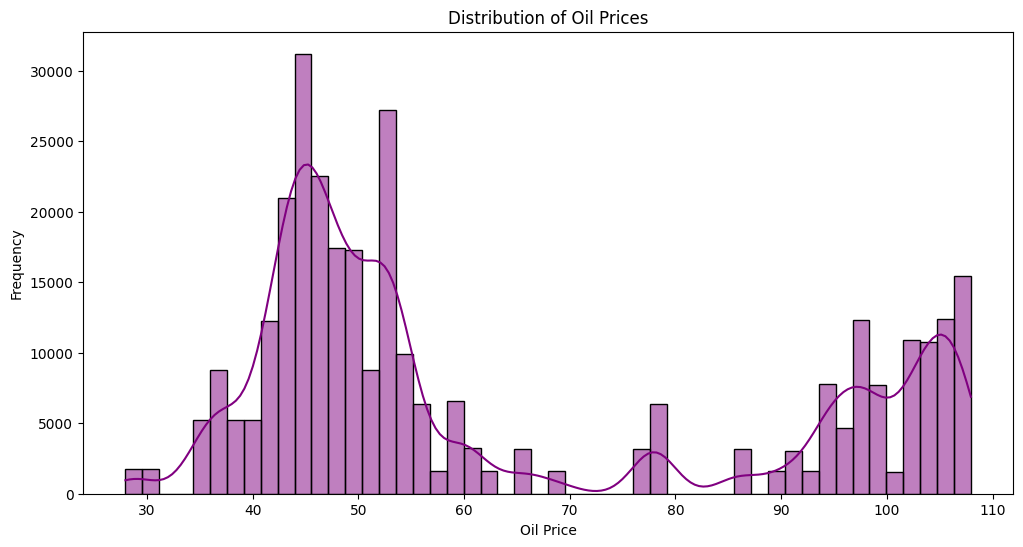

In [82]:
# Check basic information about the 'dcoilwtico' column
print(merged_data['dcoilwtico'].describe())

# Plot the distribution of oil prices
plt.figure(figsize=(12, 6))
sns.histplot(merged_data['dcoilwtico'], bins=50, kde=True, color='purple', edgecolor='black')
plt.title('Distribution of Oil Prices')
plt.xlabel('Oil Price')
plt.ylabel('Frequency')
plt.show()


### <b> Bivariate Analysis

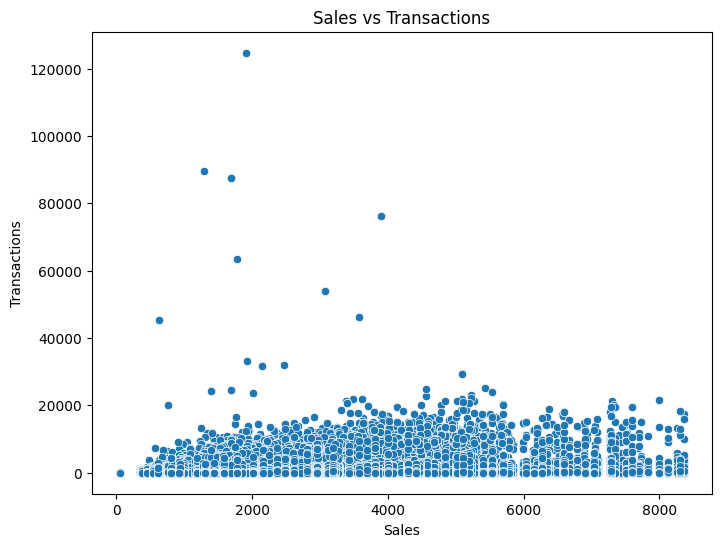

In [83]:
# Scatter plot between sales and transactions
plt.figure(figsize=(8, 6))
sns.scatterplot(data=merged_data, x='transactions', y='sales')
plt.title('Sales vs Transactions')
plt.xlabel('Sales')
plt.ylabel('Transactions')
plt.show()

The scatter plot effectively illustrates the correlation between sales and transactions within the dataset, with each data point representing a specific instance characterized by corresponding sales and transaction values. Key insights derived from the scatter plot analysis include:

1. Clustered Data Points: The majority of data points converge in the lower sales region, forming a distinct concentration. This clustering suggests consistent transaction volumes associated with particular sales levels. Such concentration may signify a recurring sales pattern or trend that manifests at specific transaction levels.

2. Outliers: Notable outliers deviate from the primary cluster, occupying positions at higher sales levels for relatively lower transaction volumes, or vice versa. These outliers represent exceptional instances where sales significantly differ from the typical observations for a given number of transactions. Identification and comprehension of these outliers offer insights into unusual sales scenarios or exceptional business activities.

In summary, the scatter plot provides valuable insights into the intricate relationship between sales and transactions. The concentration of data points around specific sales and transaction levels implies the existence of recurrent patterns. Meanwhile, outliers spotlight exceptional cases that warrant deeper exploration to comprehend the factors influencing sales and transactions in unique instances. This analytical approach equips businesses with the knowledge needed to make informed decisions and formulate effective strategies for enhancing sales performance.

#### Trend of sales over time.

In [84]:

# Group the data by date and calculate the total sales
import plotly.express as px
daily_sales = merged_data.groupby('date')['sales'].sum().reset_index()

# Create a time series plot with slider
fig = px.line(daily_sales, x='date', y='sales')
fig.update_xaxes(rangeslider_visible=True)
fig.update_layout(title='Trend of Sales Over Time', title_x=0.5)
fig.show()

## Unveiling the Sales Story: A Journey Through Time

This plot reveals the fascinating journey of sales over time, offering valuable insights into the dynamics of your business. By peering into the graph, we can observe:

1. Fluctuations and Variations: The sales line doesn't simply rise or fall in a straight line. Instead, it weaves an intricate pattern, marked by periods of both high and low sales. These fluctuations suggest the presence of underlying factors influencing the sales performance.

2. Potential Seasonality: Do you notice any recurring patterns in the peaks and valleys? These could be indicative of seasonality, where sales rise and fall predictably throughout the year. Identifying these seasonal trends can help you anticipate future sales patterns and adjust your strategies accordingly.
3. Beyond the Surface: The graph hints at the presence of other factors beyond seasonality that might be impacting sales. These could include marketing campaigns, product launches, economic events, or even changes in competitor behavior. Further analysis is needed to uncover the specific drivers behind these fluctuations.

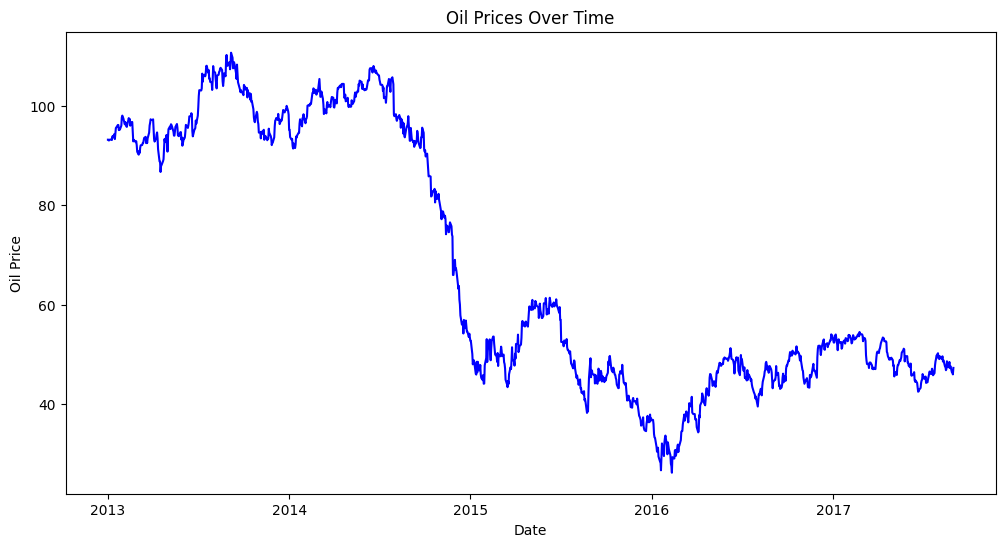

In [85]:
# Prices of oil over time 
plt.figure(figsize=(12, 6))
plt.plot(df_oil['date'], df_oil['dcoilwtico'], color='blue')
plt.title('Oil Prices Over Time')
plt.xlabel('Date')
plt.ylabel('Oil Price')
plt.grid(False)
plt.show()


We observe a consistent pattern in the trajectory of oil prices over time. Notably, there was a significant decline in oil prices towards the end of 2014, and since then, they have not experienced a recovery. Despite occasional fluctuations, current oil prices remain on par with those recorded at the beginning of 2015. This trend raises the possibility of a substantial shift in store sales around late 2014.

Upon examining the unit sales data, this trend is not immediately evident. While there appears to be a decline in sales in the early part of 2015, late 2014 shows an upward trend in sales. Additionally, it is noteworthy that the drop in oil prices does not seem to have any discernible impact on sales. A visual analysis of the sales plot reveals no correlation between the decrease in oil prices and changes in sales. Consequently, we can conclude that this particular feature or data related to oil prices holds no significance for our modeling purposes and will be excluded from consideration.

### <b> Multivariate Analysis

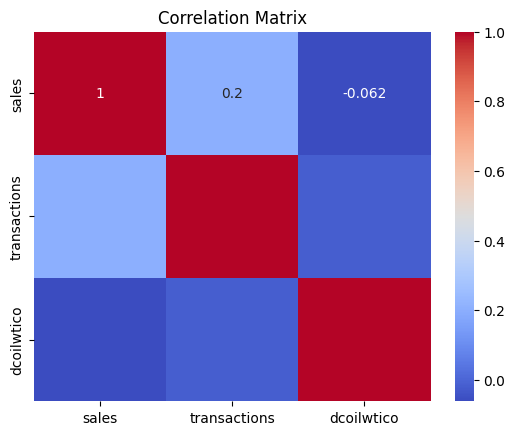

In [86]:
# Select numerical variables for correlation analysis
numerical_vars = ['sales', 'transactions', 'dcoilwtico']

# Compute correlation matrix
corr_matrix = merged_data[numerical_vars].corr()

# Plot heatmap
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm')
plt.title('Correlation Matrix')
plt.show()

Correlation values span from -1 to 1, where -1 signifies a perfect negative correlation, 1 denotes a perfect positive correlation, and 0 indicates no correlation. The correlation matrix offers insights into the relationships between variables, shedding light on their interactions. Within this matrix, we observe correlations between different variables:

1. Sales and Transactions:

A weak positive correlation of around 0.200 exists between "Sales" and "Transactions." This implies a slight positive relationship, suggesting that as the number of transactions increases, there is a tendency for sales to also increase. However, the correlation is not robust.

2. Sales and Dcoilwito (Oil Prices):

A weak negative correlation of approximately -0.062 is observed between "Sales" and "Dcoilwito" (Oil Prices). This indicates a mild negative relationship, suggesting that as oil prices increase, there is a slight tendency for sales to decrease. However, the correlation is not statistically significant.

3. Transactions and Dcoilwito (Oil Prices):

A very weak negative correlation of about -0.017 exists between "Transactions" and "Dcoilwito" (Oil Prices). This suggests an almost negligible relationship, indicating that fluctuations in oil prices have minimal impact on the number of transactions.
In summary, the correlation values are relatively low, signaling that the relationships between these variables are not robust. It's important to note that other unconsidered factors may influence sales, transactions, and oil prices. Exploring additional variables is crucial for obtaining a more comprehensive understanding of their collective impact on sales and transactions.

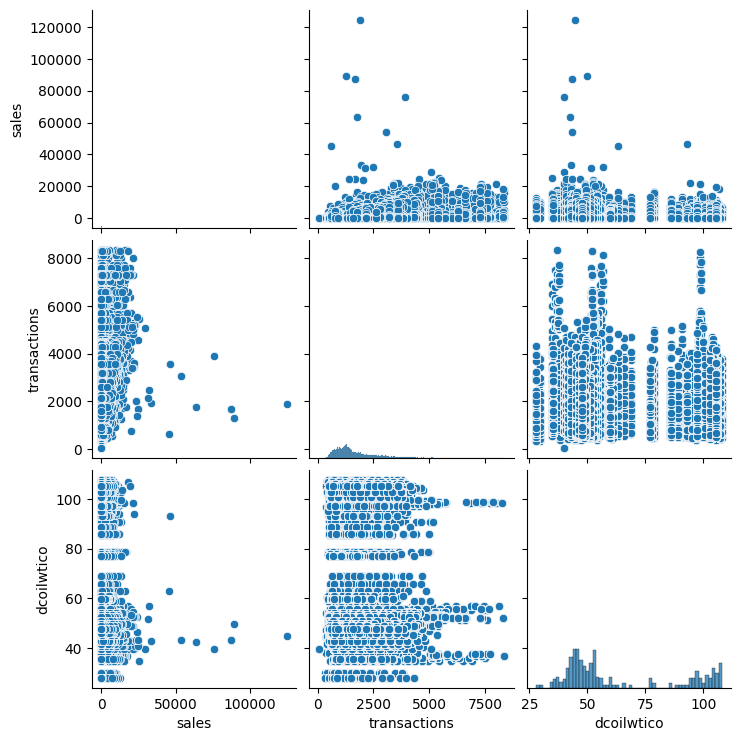

In [87]:
# Select numerical variables for correlation analysis
numerical_vars = ['sales', 'transactions', 'dcoilwtico']

# Plot scatter plot matrix
sns.pairplot(merged_data[numerical_vars])
plt.grid(False)

## Stationarity Test

Stationarity implies that the statistical properties of the time series, such as mean and variance, remain constant over time. In this case, the ADF test was conducted on the 'sales' data from the 'merged_df' dataset. To perform the stationarity test, we will use the Augmented Dickey-Fuller (ADF) test commonly used to check for stationarity in a time series.

- Null hypothesis (H0): The sales data is non-stationary.
- Alternative hypothesis (H1): The sales data is stationary. 

In [88]:
from statsmodels.tsa.stattools import kpss
sales_data = merged_data['sales']
# Perform KPSS test
kpss_result = kpss(sales_data)

# Extract statistics and p-value
kpss_statistic = kpss_result[0]
kpss_p_value = kpss_result[1]

# Print results
print(f"KPSS Test Statistics: {kpss_statistic}")
print(f"P-value: {kpss_p_value}")

if kpss_p_value <= 0.05:
    print("Reject the null hypothesis: The sales data is non-stationary.")
else:
    print("Fail to reject the null hypothesis: The sales data is stationary.")


KPSS Test Statistics: 25.945743698952356
P-value: 0.01
Reject the null hypothesis: The sales data is non-stationary.


C:\Users\HP\AppData\Local\Temp\ipykernel_24148\3010821135.py:4: InterpolationWarning:

The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.






Rejecting the null hypothesis in this context means that the sales data is stationary. This is generally desirable in time series analysis because stationary data simplifies the modeling process and makes it easier to identify patterns, trends, and seasonal variations accurately. Stationary time series data ensures that the statistical properties of the data remain consistent over time, enabling more reliable forecasting and analysis. Therefore, the result indicating stationary sales data is considered good for further analysis and modeling in this context.


### **HYPOTHESIS TESTING**

#### Null Hypothesis (H0):** There is no significant difference in sales between promoted and non-promoted items.

#### Alternative Hypothesis (H1):** Items that are promoted have significantly higher sales compared to non-promoted items.

In [89]:
# Assuming you have a DataFrame named 'df' with 'sales' and 'onpromotion' columns
promoted_sales =merged_data[merged_data['onpromotion'] == 1]['sales']
non_promoted_sales = merged_data[merged_data['onpromotion'] == 0]['sales']

# Perform two-sample t-test
t_stat, p_value = ttest_ind(promoted_sales, non_promoted_sales, equal_var=False)

# Compare p-value with significance level
alpha = 0.05
if p_value < alpha:
    print("Reject the null hypothesis. There is a statistically significant difference in sales between promoted and non-promoted items.")
else:
    print("Fail to reject the null hypothesis. There is no statistically significant difference in sales between promoted and non-promoted items.")

Reject the null hypothesis. There is a statistically significant difference in sales between promoted and non-promoted items.


The results suggests that there is statistical evidence of a significant difference in sales between promoted and non-promoted items. This can be an important finding for analysis.

## <b> Analytical Questions

1. Is the train dataset complete (has all the required dates)?
2. Which dates have the lowest and highest sales for each year?
3. Did the earthquake impact sales?
4. Are certain groups of stores selling more products? (Cluster, city, state, type)?
5. Are sales affected by promotions, oil prices and holidays?
6. What analysis can we get from the date and its extractable features?

#### 1. Is the train dataset complete (has all the required dates)?

In [90]:
min_date = train_merged_interpolated['date'].min()
max_date = train_merged_interpolated['date'].max()

# Generate a sequence of dates within the expected range
expected_dates = pd.date_range(start=min_date, end=max_date, freq='D')

# Find missing dates by comparing with the actual dates in the DataFrame
missing_dates = expected_dates[~expected_dates.isin (train_merged_interpolated['date'])]

if missing_dates.empty:
    print("The dataset is complete, and there are no missing dates.")
else:
    print("The dataset has missing dates:")
    print(missing_dates)


The dataset has missing dates:
DatetimeIndex(['2013-12-25', '2014-12-25', '2015-12-25', '2016-12-25'], dtype='datetime64[ns]', freq=None)


#### 2.Which dates have the lowest and highest sales for each year?

In [91]:
merged_data['year'] = merged_data['date'].dt.year  # Create a new column for the year

# Find dates with the lowest and highest sales for each year
min_sales_dates = merged_data.loc[merged_data.groupby('year')['sales'].idxmin()][['year', 'date', 'sales']]
max_sales_dates = merged_data.loc[merged_data.groupby('year')['sales'].idxmax()][['year', 'date', 'sales']]

# Display the results
print("Dates with the Lowest Sales for Each Year:")
print(min_sales_dates)

print("\nDates with the Highest Sales for Each Year:")
print(max_sales_dates)

Dates with the Lowest Sales for Each Year:
        year       date  sales
322007  2013 2013-01-01    0.0
321933  2014 2014-01-01    0.0
322034  2015 2015-01-01    0.0
186771  2016 2016-02-08    0.0
285961  2017 2017-01-02    0.0

Dates with the Highest Sales for Each Year:
        year       date     sales
35594   2013 2013-11-12   46271.0
107336  2014 2014-12-08   45361.0
167462  2015 2015-11-11   33274.0
218195  2016 2016-05-02  124717.0
285025  2017 2017-01-02   23966.0


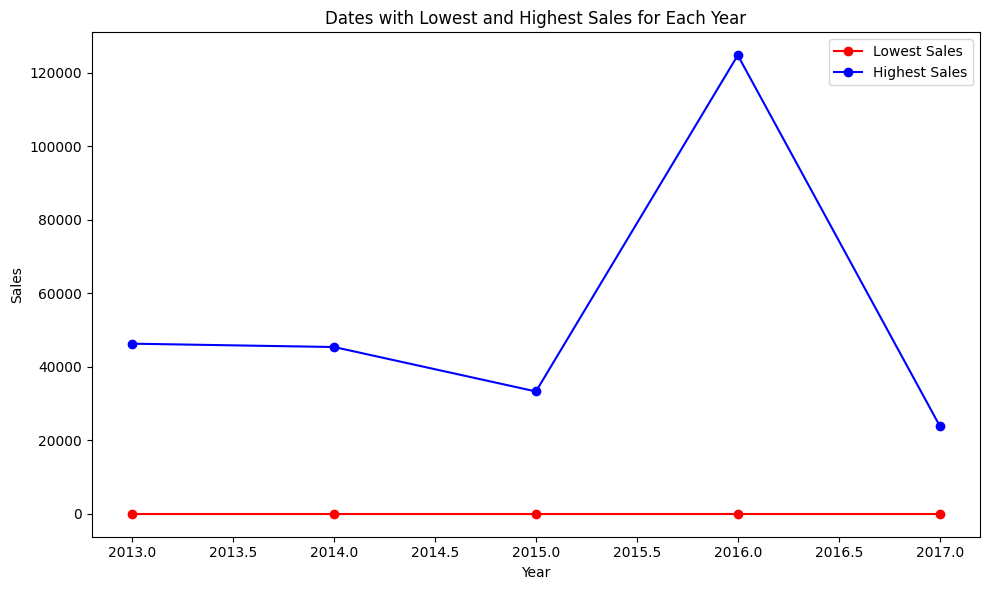

In [92]:
import matplotlib.pyplot as plt

# Create a line plot
plt.figure(figsize=(10, 6))

# Plot lowest sales dates
plt.plot(min_sales_dates['year'], min_sales_dates['sales'], marker='o', linestyle='-', color='red', label='Lowest Sales')

# Plot highest sales dates
plt.plot(max_sales_dates['year'], max_sales_dates['sales'], marker='o', linestyle='-', color='blue', label='Highest Sales')

# Set labels and title
plt.xlabel('Year')
plt.ylabel('Sales')
plt.title('Dates with Lowest and Highest Sales for Each Year')
plt.legend()

# Show the plot
plt.grid(False)
plt.tight_layout()
plt.show()


###Observations and Deductions

#### Seasonal Trends
The analysis reveals a consistent trend where the lowest sales tend to occur at the beginning of the year, particularly around January 1st. Several factors could contribute to this pattern, including post-holiday lulls, reduced consumer spending after the holiday season, or inventory adjustments by businesses.

#### Anomalies
One notable anomaly is observed in 2016, where the lowest sales occurred on February 8th. This anomaly might indicate a specific event or circumstance that impacted sales on that particular day, warranting further investigation into the underlying causes.

#### High Sales Events
In contrast to the lowest sales dates, the highest sales dates appear to be more dispersed throughout the year, with significant peaks occurring in different months. This variability suggests the influence of specific events, promotions, or seasonal factors that drive consumer spending at different times of the year.

#### Yearly Variances
Each year demonstrates its unique sales patterns, characterized by fluctuations in both the lowest and highest sales dates. Understanding these variations is crucial for businesses to effectively plan inventory management, devise targeted marketing strategies, and accurately forecast sales trends.

#### Conclusion
Analyzing the dates with the lowest and highest sales for each year provides valuable insights into sales trends, seasonality, and factors influencing consumer behavior throughout the year. This information equips businesses with the knowledge needed to optimize operations, capitalize on peak sales periods, and address challenges during slower periods, ultimately enhancing overall performance and competitiveness in the market.


### 3. Did the earthquake impact sales?

A magnitude 7.8 earthquake struck Ecuador on April 16, 2016. People rallied in relief efforts donating water and other first need products which greatly affected supermarket sales for several weeks after the earthquake.

<b> 1. Do items on promotion sell more, and is this difference statistically significant?

Total Sales Before Earthquake: 35458093.6330323
Total Sales During Earthquake: 0.0
Total Sales After Earthquake: 36871117.4033854


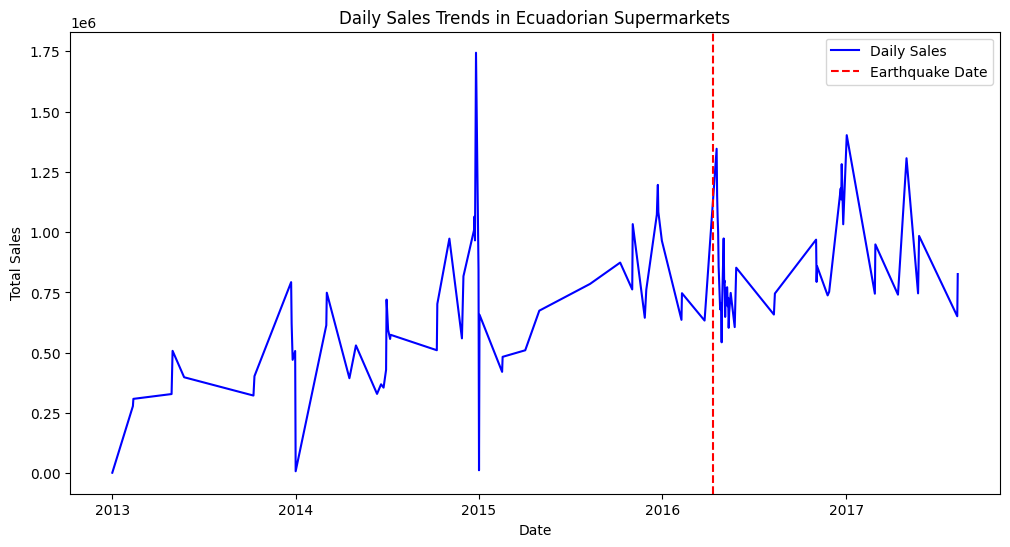

In [93]:

# Filter data for Ecuadorian supermarkets
ecuador_data = merged_data[merged_data['locale_name'] == 'Ecuador']

# Define the date range around the earthquake
earthquake_date = pd.to_datetime('2016-04-10')  # Convert earthquake date to datetime object

# Filter data for the specified date range
earthquake_data = ecuador_data[ecuador_data['date'] == earthquake_date]

# Aggregate sales for the days before, during, and after the earthquake
sales_before = ecuador_data[ecuador_data['date'] < earthquake_date]['sales'].sum()
sales_during = earthquake_data['sales'].sum()
sales_after = ecuador_data[ecuador_data['date'] > earthquake_date]['sales'].sum()

# Compare sales before, during, and after the earthquake
print("Total Sales Before Earthquake:", sales_before)
print("Total Sales During Earthquake:", sales_during)
print("Total Sales After Earthquake:", sales_after)

# Group data by date and calculate total sales
sales_by_date = ecuador_data.groupby('date')['sales'].sum()

# Plot the sales trends
plt.figure(figsize=(12, 6))
plt.plot(sales_by_date, color='blue', label='Daily Sales')
plt.title('Daily Sales Trends in Ecuadorian Supermarkets')
plt.xlabel('Date')
plt.ylabel('Total Sales')
plt.axvline(x=earthquake_date, color='red', linestyle='--', label='Earthquake Date')
plt.legend()
plt.grid(False)
plt.show()


#### Summary of Sales Observation Before, During, and After Earthquake

- **Total Sales Before Earthquake**: \( 35,458,093.63 \)

- **Total Sales During Earthquake**: \( 0.0 \)

- **Total Sales After Earthquake**: \( 36,871,117.40 \)

### Explanation:

- **Before Earthquake**: The total sales in Ecuadorian supermarkets before the earthquake were substantial, indicating regular consumer activity and economic transactions.

- **During Earthquake**: On the day of the earthquake (April 10, 2016), there were no recorded sales. This could be due to various reasons such as store closures, disrupted operations, or decreased consumer activity due to the earthquake's immediate impact.

- **After Earthquake**: Following the earthquake, the total sales increased significantly, reaching approximately \( 36.8 \) million. This increase could be attributed to recovery efforts, increased consumer spending after the immediate impact subsided, or other economic factors.

This observation underscores the influence of natural disasters on consumer behavior and economic activity, as reflected in the sales data of Ecuadorian supermarkets.


#### 4. Determine if certain groups of stores sell more products

In [94]:
# Group by cluster and calculate the average sales
average_sales_by_cluster = merged_data.groupby('cluster')['sales'].mean()

# Group by city and calculate the average sales
average_sales_by_city = merged_data.groupby('city')['sales'].mean()

# Group by state and calculate the average sales
average_sales_by_state = merged_data.groupby('state')['sales'].mean()

# Group by store type and calculate the average sales
average_sales_by_store_type = merged_data.groupby('store_type')['sales'].mean()

# Set the number of bars in each plot
num_bars = len(average_sales_by_cluster)

# Generate the colors using the viridis palette
colors = plt.cm.viridis(np.linspace(0, 1, num_bars))

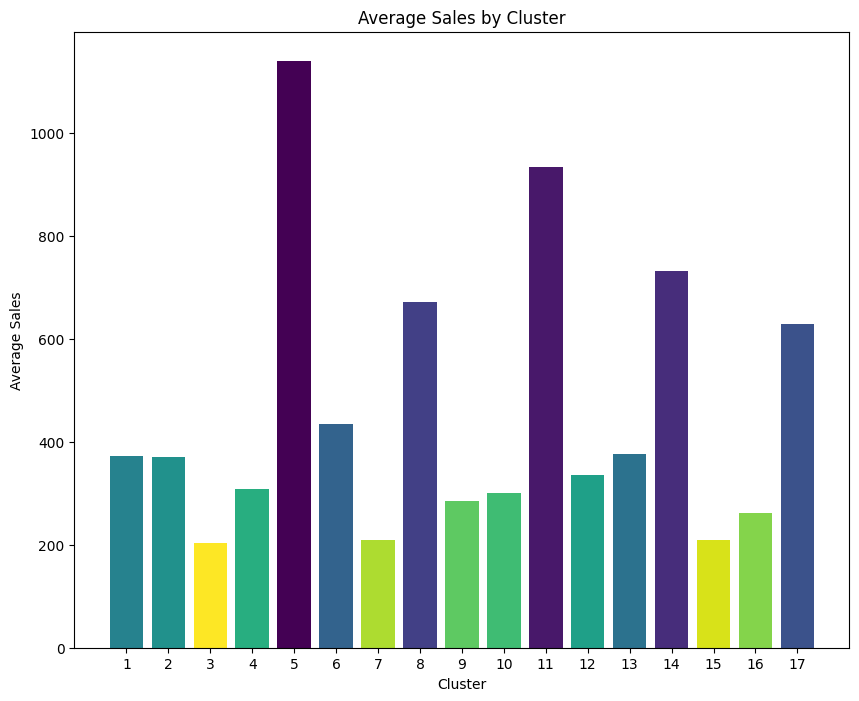

In [95]:
# Sort the data by average sales in descending order
average_sales_by_cluster = average_sales_by_cluster.sort_values(ascending=False)

# Plot the average sales by cluster
plt.figure(figsize=(10, 8))
plt.bar(average_sales_by_cluster.index, average_sales_by_cluster.values, color=colors)
plt.xlabel('Cluster')
plt.ylabel('Average Sales')
plt.title('Average Sales by Cluster')

# Set the x-tick labels as integers
plt.xticks(range(1, len(average_sales_by_cluster.index) + 1))
plt.show()

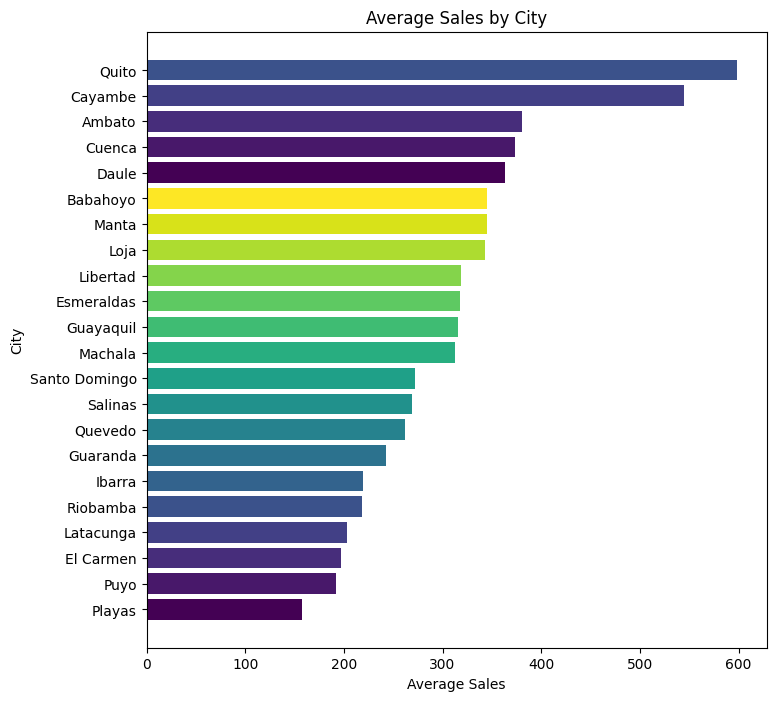

In [96]:
# Sort the data by average sales in descending order
average_sales_by_city = average_sales_by_city.sort_values(ascending=True)

# Plot the average sales by city horizontally
plt.figure(figsize=(8, 8))
plt.barh(average_sales_by_city.index, average_sales_by_city.values, color=colors)
plt.xlabel('Average Sales')
plt.ylabel('City')
plt.title('Average Sales by City')
plt.show()# Sort the data by average sales in descending order
average_sales_by_city = average_sales_by_city.sort_values(ascending=True)



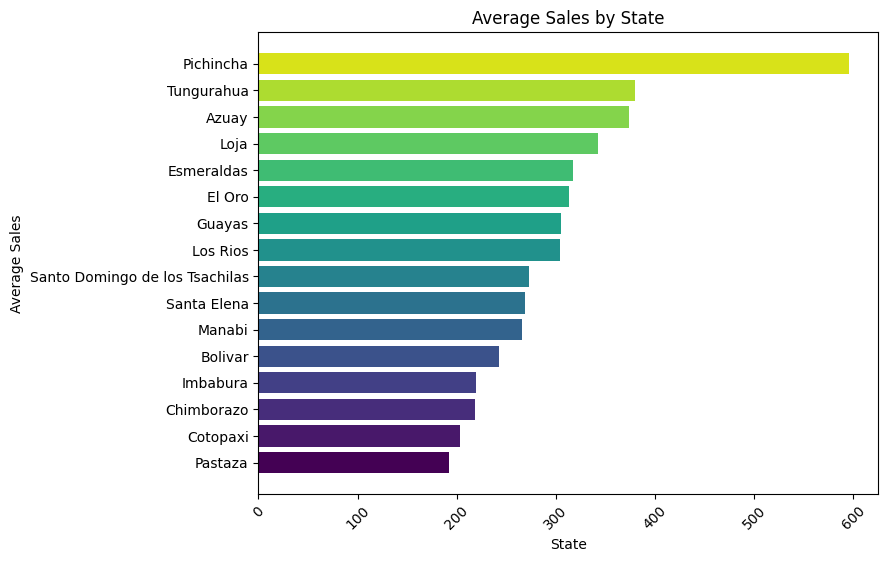

In [97]:
# Sort the data by average sales in descending order
average_sales_by_state = average_sales_by_state.sort_values(ascending=True)

# Plot the average sales by state
plt.figure(figsize=(8, 6))
plt.barh(average_sales_by_state.index, average_sales_by_state.values, color=colors)
plt.xlabel('State')
plt.ylabel('Average Sales')
plt.title('Average Sales by State')
plt.xticks(rotation=45)
plt.show()

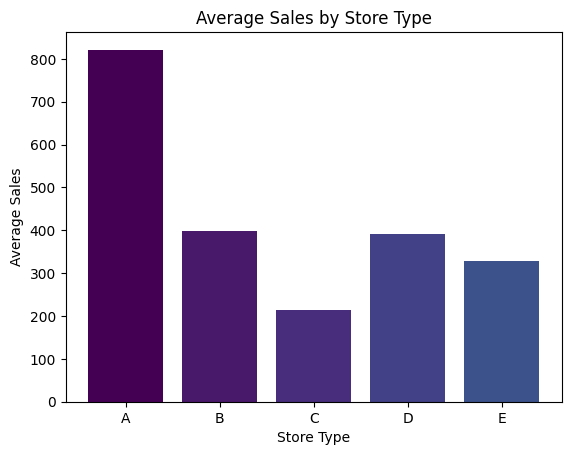

In [98]:
# Plot the average sales by store type
plt.bar(average_sales_by_store_type.index, average_sales_by_store_type.values, color=colors)
plt.xlabel('Store Type')
plt.ylabel('Average Sales')
plt.title('Average Sales by Store Type')
plt.show()

#### 5. Are sales affected by promotions, oil prices and holidays?

In [99]:
# Calculate correlations between sales and promotions, oil prices, holidays
corr_sales_promotions = merged_data['sales'].corr(merged_data['onpromotion'])
corr_sales_oil = merged_data['sales'].corr(merged_data['dcoilwtico'])
corr_sales_holidays = merged_data['sales'].corr(merged_data['holiday_type'] == 'Holiday')

# Print the correlation values
print(f"Correlation between Sales and Promotions: {corr_sales_promotions}")
print(f"Correlation between Sales and Oil Prices: {corr_sales_oil}")
print(f"Correlation between Sales and Holidays: {corr_sales_holidays}")

Correlation between Sales and Promotions: 0.41802891972423817
Correlation between Sales and Oil Prices: -0.06150915261069546
Correlation between Sales and Holidays: -0.03706892930251641


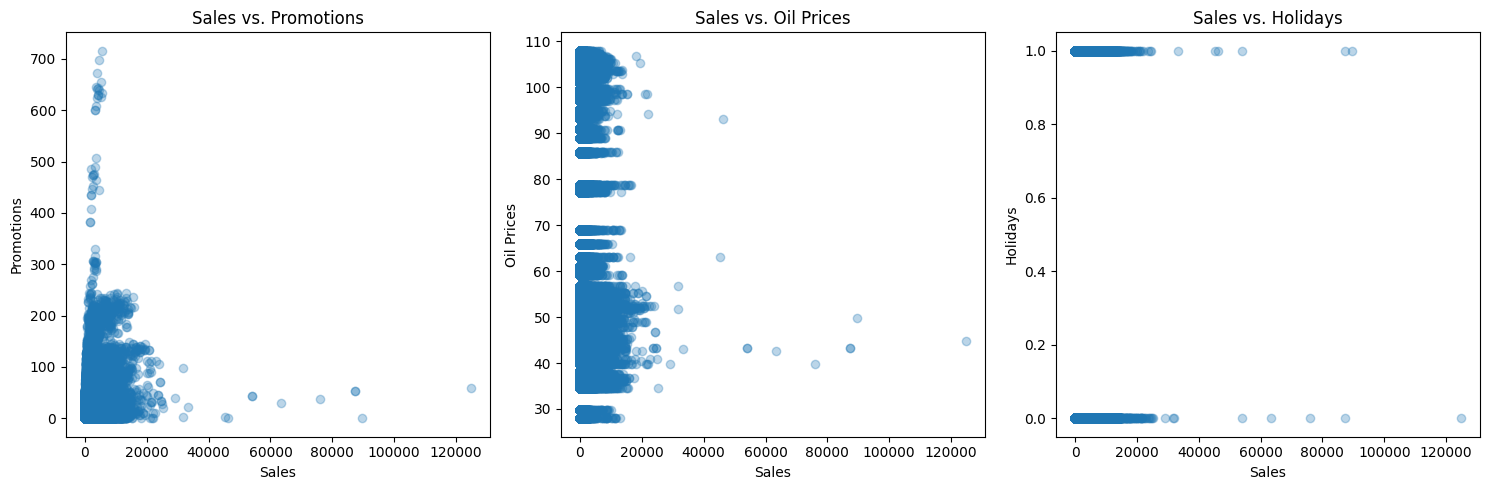

In [100]:
# Visualize relationships using scatter plots
plt.figure(figsize=(15, 5))

# Scatter plot for Sales vs. Promotions
plt.subplot(1, 3, 1)
plt.scatter(merged_data['sales'], merged_data['onpromotion'], alpha=0.3)
plt.title('Sales vs. Promotions')
plt.xlabel('Sales')
plt.ylabel('Promotions')

# Scatter plot for Sales vs. Oil Prices
plt.subplot(1, 3, 2)
plt.scatter(merged_data['sales'], merged_data['dcoilwtico'], alpha=0.3)
plt.title('Sales vs. Oil Prices')
plt.xlabel('Sales')
plt.ylabel('Oil Prices')

# Scatter plot for Sales vs. Holidays
plt.subplot(1, 3, 3)
plt.scatter(merged_data['sales'], (merged_data['holiday_type'] == 'Holiday'), alpha=0.3)
plt.title('Sales vs. Holidays')
plt.xlabel('Sales')
plt.ylabel('Holidays')

# Adjust layout
plt.tight_layout()

# Display the plots
plt.show()


1. Promotions:
The analysis reveals a positive correlation of approximately 0.42 between sales and promotions. This indicates a moderate positive impact of promotions on sales. During promotional periods, there is an increased likelihood of observing higher sales. This positive correlation suggests that customers tend to respond favorably to promotional offers, contributing to an uptick in sales.

2. Oil Prices:
A weak negative correlation of approximately -0.06 is observed between sales and oil prices. This suggests a slight negative relationship between sales and oil prices, although the correlation is close to zero. The findings imply that fluctuations in oil prices have minimal impact on sales. The weak negative correlation indicates that, on average, there is no strong evidence to suggest that changes in oil prices significantly influence customer purchasing behavior or overall sales.

3. Holidays:
A very weak negative correlation of approximately -0.04 is found between sales and holidays. This implies that there is almost no discernible relationship between sales and holidays. The data suggests that holidays, whether they are observed or not, do not appear to significantly impact sales. The negligible correlation underscores that holidays are unlikely to be a major factor influencing variations in sales.

In summary, promotions exhibit a relatively stronger influence on sales compared to oil prices and holidays. While promotions positively impact sales, the analysis suggests that oil prices and holidays show minimal or no discernible relationship with sales. This nuanced understanding can help businesses tailor their strategies, placing a greater emphasis on promotional efforts to drive sales.

#### 6. What analysis can we get from the date and its extractable features?

In [101]:
# Extracting Date Components
merged_df_copy['date'] = pd.to_datetime(merged_df_copy['date'])
merged_df_copy['year'] = merged_df_copy['date'].dt.year
merged_df_copy['month'] = merged_df_copy['date'].dt.month
merged_df_copy['day'] = merged_df_copy['date'].dt.day
merged_df_copy.head()

,date,store_nbr,family,sales,onpromotion,city,state,store_type,cluster,transactions,holiday_type,locale,locale_name,description,transferred,dcoilwtico,year,month,day
322007,2013-01-01,25.0,SCHOOL AND OFFICE SUPPLIES,0.000,0.0,Salinas,Santa Elena,D,1,770,Holiday,National,Ecuador,Primer dia del ano,False,93.139999,2013,1,1
322013,2013-01-01,25.0,PERSONAL CARE,25.000,0.0,Salinas,Santa Elena,D,1,770,Holiday,National,Ecuador,Primer dia del ano,False,93.139999,2013,1,1
322012,2013-01-01,25.0,PET SUPPLIES,0.000,0.0,Salinas,Santa Elena,D,1,770,Holiday,National,Ecuador,Primer dia del ano,False,93.139999,2013,1,1
322011,2013-01-01,25.0,PLAYERS AND ELECTRONICS,0.000,0.0,Salinas,Santa Elena,D,1,770,Holiday,National,Ecuador,Primer dia del ano,False,93.139999,2013,1,1
322010,2013-01-01,25.0,POULTRY,42.637,0.0,Salinas,Santa Elena,D,1,770,Holiday,National,Ecuador,Primer dia del ano,False,93.139999,2013,1,1


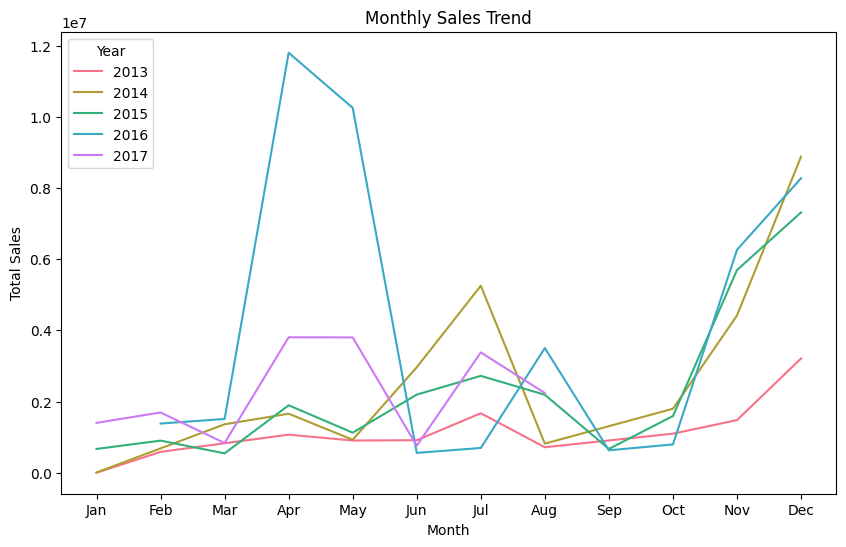

In [102]:
# Set distinct colors for each year
colors = sns.color_palette("husl", n_colors=len(merged_df_copy['year'].unique()))

# Visualize the Monthly Sales Trend
monthly_sales = merged_df_copy.groupby(['year', 'month'])['sales'].sum().reset_index()
plt.figure(figsize=(10, 6))
sns.lineplot(data=monthly_sales, x='month', y='sales', hue='year', palette=colors)
plt.title('Monthly Sales Trend')
plt.xlabel('Month')
plt.ylabel('Total Sales')
plt.xticks(range(1, 13), labels=['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'])
plt.legend(title='Year')
plt.show()

The line plot depicting the monthly sales trend shows variations in sales throughout the year.
Sales seem to dip during the middle months of the year (July to September) before rising again in the last quarter (October to December), with the highest sales in December.
The year-wise color distinction helps to observe sales patterns for each year.

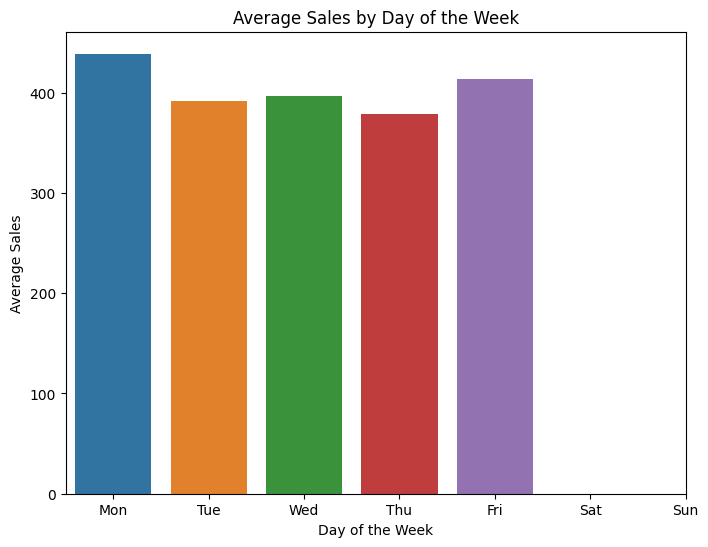

In [103]:
# Visualize the Day of the Week Sales Pattern
merged_df_copy['day_of_week'] = merged_df_copy['date'].dt.dayofweek
day_of_week_sales = merged_df_copy.groupby('day_of_week')['sales'].mean().reset_index()
plt.figure(figsize=(8, 6))
sns.barplot(data=day_of_week_sales, x='day_of_week', y='sales')
plt.title('Average Sales by Day of the Week')
plt.xlabel('Day of the Week')
plt.ylabel('Average Sales')
plt.xticks(range(7), labels=['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun'])
plt.show()

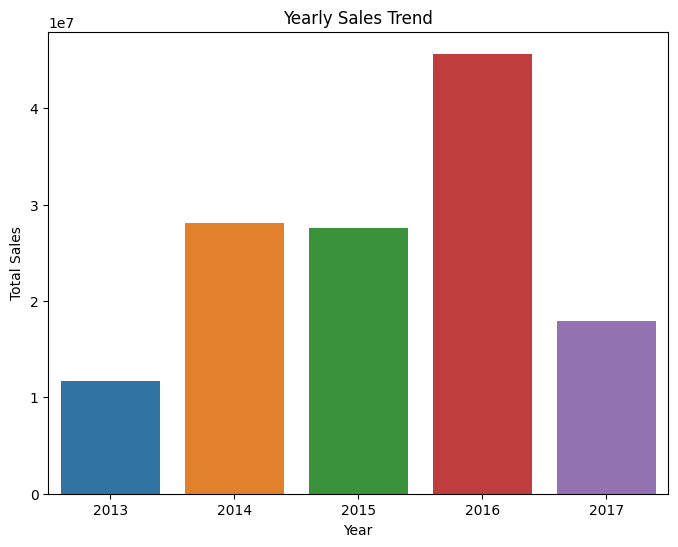

In [104]:
# Visualize the Yearly Sales Trend
yearly_sales = merged_df_copy.groupby('year')['sales'].sum().reset_index()
plt.figure(figsize=(8, 6))
sns.barplot(data=yearly_sales, x='year', y='sales')
plt.title('Yearly Sales Trend')
plt.xlabel('Year')
plt.ylabel('Total Sales')
plt.show()# Visualize the Yearly Sales Trend


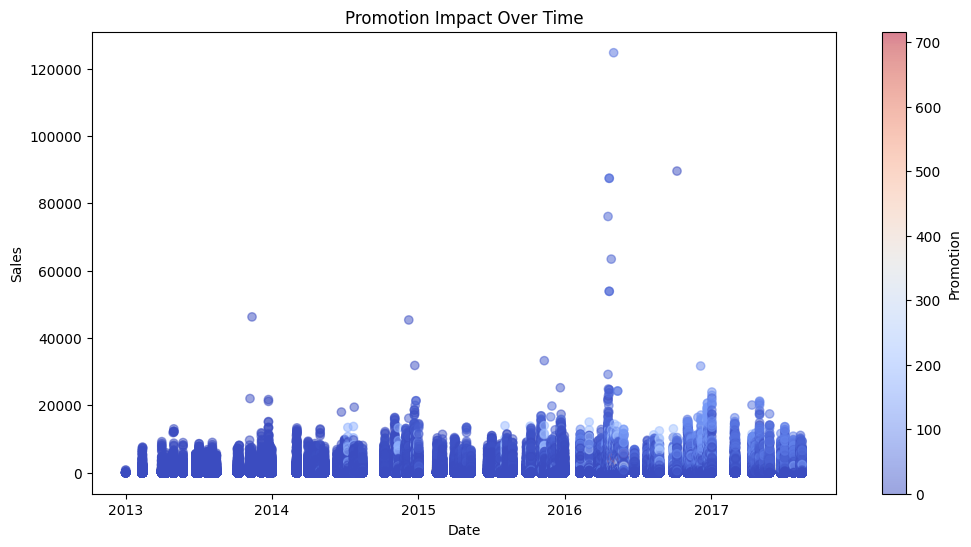

In [105]:
# Promotion Impact Over Time
plt.figure(figsize=(12, 6))
plt.scatter(merged_data['date'], merged_data['sales'], c=merged_data['onpromotion'], cmap='coolwarm', alpha=0.5)
plt.title('Promotion Impact Over Time')
plt.xlabel('Date')
plt.ylabel('Sales')
plt.colorbar(label='Promotion')
plt.show()


Stationarity implies that the statistical properties of the time series, such as mean and variance, remain constant over time. In this case, the ADF test was conducted on the 'sales' data from the 'merged_df' dataset. To perform the stationarity test, we will use the Augmented Dickey-Fuller (ADF) test commonly used to check for stationarity in a time series.

- Null hypothesis (H0): The sales data is non-stationary.
- Alternative hypothesis (H1): The sales data is stationary. 

# <b> Feature Enginering

## Train Dataset

Extracting Date Components (Day, Month, Year and Day of The Week).


In [106]:
# Extracting Date Components
merged_df_copy['date'] = pd.to_datetime(merged_df_copy['date'])
merged_df_copy['year'] = merged_df_copy['date'].dt.year
merged_df_copy['month'] = merged_df_copy['date'].dt.month
merged_df_copy['day'] = merged_df_copy['date'].dt.day
merged_df_copy.head()

,date,store_nbr,family,sales,onpromotion,city,state,store_type,cluster,transactions,holiday_type,locale,locale_name,description,transferred,dcoilwtico,year,month,day,day_of_week
322007,2013-01-01,25.0,SCHOOL AND OFFICE SUPPLIES,0.000,0.0,Salinas,Santa Elena,D,1,770,Holiday,National,Ecuador,Primer dia del ano,False,93.139999,2013,1,1,1
322013,2013-01-01,25.0,PERSONAL CARE,25.000,0.0,Salinas,Santa Elena,D,1,770,Holiday,National,Ecuador,Primer dia del ano,False,93.139999,2013,1,1,1
322012,2013-01-01,25.0,PET SUPPLIES,0.000,0.0,Salinas,Santa Elena,D,1,770,Holiday,National,Ecuador,Primer dia del ano,False,93.139999,2013,1,1,1
322011,2013-01-01,25.0,PLAYERS AND ELECTRONICS,0.000,0.0,Salinas,Santa Elena,D,1,770,Holiday,National,Ecuador,Primer dia del ano,False,93.139999,2013,1,1,1
322010,2013-01-01,25.0,POULTRY,42.637,0.0,Salinas,Santa Elena,D,1,770,Holiday,National,Ecuador,Primer dia del ano,False,93.139999,2013,1,1,1


### Dropping Unneccessary Columns in The Merged and Test Datasets as it is not needed for our analysis

In [107]:
columns_to_drop = ['date', 'locale', 'locale_name', 'description', 'store_type', 'transferred', 'state']
merged_df_copy = merged_df_copy.drop(columns=columns_to_drop)

merged_df_copy.head()

,store_nbr,family,sales,onpromotion,city,cluster,transactions,holiday_type,dcoilwtico,year,month,day,day_of_week
322007,25.0,SCHOOL AND OFFICE SUPPLIES,0.000,0.0,Salinas,1,770,Holiday,93.139999,2013,1,1,1
322013,25.0,PERSONAL CARE,25.000,0.0,Salinas,1,770,Holiday,93.139999,2013,1,1,1
322012,25.0,PET SUPPLIES,0.000,0.0,Salinas,1,770,Holiday,93.139999,2013,1,1,1
322011,25.0,PLAYERS AND ELECTRONICS,0.000,0.0,Salinas,1,770,Holiday,93.139999,2013,1,1,1
322010,25.0,POULTRY,42.637,0.0,Salinas,1,770,Holiday,93.139999,2013,1,1,1


### Product Categorization Based on Families

In [108]:
unique_families = merged_df_copy['family'].unique()
unique_families

array(['SCHOOL AND OFFICE SUPPLIES', 'PERSONAL CARE', 'PET SUPPLIES',
       'PLAYERS AND ELECTRONICS', 'POULTRY', 'PREPARED FOODS', 'PRODUCE',
       'SEAFOOD', 'MAGAZINES', 'MEATS', 'LIQUOR,WINE,BEER', 'DAIRY',
       'BABY CARE', 'BEAUTY', 'BEVERAGES', 'BOOKS', 'AUTOMOTIVE',
       'CELEBRATION', 'LAWN AND GARDEN', 'LADIESWEAR', 'HOME CARE',
       'HOME APPLIANCES', 'BREAD/BAKERY', 'HOME AND KITCHEN I',
       'HARDWARE', 'HOME AND KITCHEN II', 'GROCERY I', 'FROZEN FOODS',
       'EGGS', 'LINGERIE', 'DELI', 'CLEANING', 'GROCERY II'], dtype=object)

In [109]:
# Define the category lists for each product category
food_families = ['BEVERAGES', 'BREAD/BAKERY', 'FROZEN FOODS', 'MEATS', 'PREPARED FOODS', 'DELI','PRODUCE', 'DAIRY','POULTRY','EGGS','SEAFOOD']
home_families = ['HOME AND KITCHEN I', 'HOME AND KITCHEN II', 'HOME APPLIANCES']
clothing_families = ['LINGERIE', 'LADYSWARE']
grocery_families = ['GROCERY I', 'GROCERY II']
stationery_families = ['BOOKS', 'MAGAZINES','SCHOOL AND OFFICE SUPPLIES']
cleaning_families = ['HOME CARE', 'BABY CARE','PERSONAL CARE']
hardware_families = ['PLAYERS AND ELECTRONICS','HARDWARE']

# Categorize the 'family' column based on the product categories
merged_df_copy['family'] = np.where(merged_df_copy['family'].isin(food_families), 'FOODS', merged_df_copy['family'])
merged_df_copy['family'] = np.where(merged_df_copy['family'].isin(home_families), 'HOME', merged_df_copy['family'])
merged_df_copy['family'] = np.where(merged_df_copy['family'].isin(clothing_families), 'CLOTHING', merged_df_copy['family'])
merged_df_copy['family'] = np.where(merged_df_copy['family'].isin(grocery_families), 'GROCERY', merged_df_copy['family'])
merged_df_copy['family'] = np.where(merged_df_copy['family'].isin(stationery_families), 'STATIONERY', merged_df_copy['family'])
merged_df_copy['family'] = np.where(merged_df_copy['family'].isin(cleaning_families), 'CLEANING', merged_df_copy['family'])
merged_df_copy['family'] = np.where(merged_df_copy['family'].isin(hardware_families), 'HARDWARE', merged_df_copy['family'])

# Print the updated DataFrame
merged_df_copy.head()

,store_nbr,family,sales,onpromotion,city,cluster,transactions,holiday_type,dcoilwtico,year,month,day,day_of_week
322007,25.0,STATIONERY,0.000,0.0,Salinas,1,770,Holiday,93.139999,2013,1,1,1
322013,25.0,CLEANING,25.000,0.0,Salinas,1,770,Holiday,93.139999,2013,1,1,1
322012,25.0,PET SUPPLIES,0.000,0.0,Salinas,1,770,Holiday,93.139999,2013,1,1,1
322011,25.0,HARDWARE,0.000,0.0,Salinas,1,770,Holiday,93.139999,2013,1,1,1
322010,25.0,FOODS,42.637,0.0,Salinas,1,770,Holiday,93.139999,2013,1,1,1


### Feature Scaling

In [110]:
# Scaling Numeric Variables (Min-Max Scaling)
# create an instance of StandardScaler
scaler = StandardScaler()

# select numerical columns
num_cols = ['sales', 'transactions', 'dcoilwtico']

# fit and transform the numerical columns
merged_df_copy[num_cols] = scaler.fit_transform(merged_df_copy[num_cols])

# Display the updated dataframe
merged_df_copy.head()

,store_nbr,family,sales,onpromotion,city,cluster,transactions,holiday_type,dcoilwtico,year,month,day,day_of_week
322007,25.0,STATIONERY,-0.325920,0.0,Salinas,1,-0.917916,Holiday,1.186995,2013,1,1,1
322013,25.0,CLEANING,-0.305870,0.0,Salinas,1,-0.917916,Holiday,1.186995,2013,1,1,1
322012,25.0,PET SUPPLIES,-0.325920,0.0,Salinas,1,-0.917916,Holiday,1.186995,2013,1,1,1
322011,25.0,HARDWARE,-0.325920,0.0,Salinas,1,-0.917916,Holiday,1.186995,2013,1,1,1
322010,25.0,FOODS,-0.291725,0.0,Salinas,1,-0.917916,Holiday,1.186995,2013,1,1,1


### Encoding The Categorical Variables

In [111]:
# Define the categorical columns to encode
categorical_columns = ["family", "city", "holiday_type"]

# Perform one-hot encoding
encoder = OneHotEncoder()
one_hot_encoded_data = encoder.fit_transform(merged_df_copy[categorical_columns])

# Create column names for the one-hot encoded data
column_names = encoder.get_feature_names_out(categorical_columns)

# Convert the one-hot encoded data to a DataFrame
merged_df_encoded = pd.DataFrame(one_hot_encoded_data.toarray(), columns=column_names)

# Concatenate the original dataframe with the one-hot encoded data
merged_df_encoded = pd.concat([merged_df_copy, merged_df_encoded], axis=1)

# Drop the original categorical columns
merged_df_encoded.drop(categorical_columns, axis=1, inplace=True)

# Print the head of the encoded DataFrame
merged_df_encoded.head()

,store_nbr,sales,onpromotion,cluster,transactions,dcoilwtico,year,month,day,day_of_week,...,city_Quevedo,city_Quito,city_Riobamba,city_Salinas,city_Santo Domingo,holiday_type_Additional,holiday_type_Bridge,holiday_type_Event,holiday_type_Holiday,holiday_type_Transfer
322007,25.0,-0.325920,0.0,1,-0.917916,1.186995,2013,1,1,1,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
322013,25.0,-0.305870,0.0,1,-0.917916,1.186995,2013,1,1,1,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
322012,25.0,-0.325920,0.0,1,-0.917916,1.186995,2013,1,1,1,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
322011,25.0,-0.325920,0.0,1,-0.917916,1.186995,2013,1,1,1,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
322010,25.0,-0.291725,0.0,1,-0.917916,1.186995,2013,1,1,1,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0


## Test_df

In [112]:
# Extracting Date Components
df_test['date'] = pd.to_datetime(df_test['date'])
df_test['year'] = df_test['date'].dt.year
df_test['month'] = df_test['date'].dt.month
df_test['day'] = df_test['date'].dt.day
df_test.head()

,id,date,store_nbr,family,onpromotion,year,month,day
0,3000888,2017-08-16,1,AUTOMOTIVE,0,2017,8,16
1,3000889,2017-08-16,1,BABY CARE,0,2017,8,16
2,3000890,2017-08-16,1,BEAUTY,2,2017,8,16
3,3000891,2017-08-16,1,BEVERAGES,20,2017,8,16
4,3000892,2017-08-16,1,BOOKS,0,2017,8,16


In [113]:
# Dropping Unnecessary Columns
columns_to_drop = ['date', 'id']
df_test = df_test.drop(columns=columns_to_drop)
df_test.head()

,store_nbr,family,onpromotion,year,month,day
0,1,AUTOMOTIVE,0,2017,8,16
1,1,BABY CARE,0,2017,8,16
2,1,BEAUTY,2,2017,8,16
3,1,BEVERAGES,20,2017,8,16
4,1,BOOKS,0,2017,8,16


In [114]:
# Product Categorization Based on Families
food_families = ['BEVERAGES', 'BREAD/BAKERY', 'FROZEN FOODS', 'MEATS', 'PREPARED FOODS', 'DELI', 'PRODUCE', 'DAIRY', 'POULTRY', 'EGGS', 'SEAFOOD']
home_families = ['HOME AND KITCHEN I', 'HOME AND KITCHEN II', 'HOME APPLIANCES']
clothing_families = ['LINGERIE', 'LADYSWARE']
grocery_families = ['GROCERY I', 'GROCERY II']
stationery_families = ['BOOKS', 'MAGAZINES', 'SCHOOL AND OFFICE SUPPLIES']
cleaning_families = ['HOME CARE', 'BABY CARE', 'PERSONAL CARE']
hardware_families = ['PLAYERS AND ELECTRONICS', 'HARDWARE']

df_test['family'] = np.where(df_test['family'].isin(food_families), 'FOODS', df_test['family'])
df_test['family'] = np.where(df_test['family'].isin(home_families), 'HOME', df_test['family'])
df_test['family'] = np.where(df_test['family'].isin(clothing_families), 'CLOTHING', df_test['family'])
df_test['family'] = np.where(df_test['family'].isin(grocery_families), 'GROCERY', df_test['family'])
df_test['family'] = np.where(df_test['family'].isin(stationery_families), 'STATIONERY', df_test['family'])
df_test['family'] = np.where(df_test['family'].isin(cleaning_families), 'CLEANING', df_test['family'])
df_test['family'] = np.where(df_test['family'].isin(hardware_families), 'HARDWARE', df_test['family'])

# Print the updated DataFrame
df_test.head()

,store_nbr,family,onpromotion,year,month,day
0,1,AUTOMOTIVE,0,2017,8,16
1,1,CLEANING,0,2017,8,16
2,1,BEAUTY,2,2017,8,16
3,1,FOODS,20,2017,8,16
4,1,STATIONERY,0,2017,8,16


In [115]:
# Encoding The Categorical Variables
# List of categorical columns to encode
categorical_columns = ["family"]

# Create an instance of the OneHotEncoder
encoder = OneHotEncoder()

# Perform one-hot encoding on the 'df_test' data for the specified categorical columns
one_hot_encoded_data = encoder.fit_transform(df_test[categorical_columns])

# Get the column names for the one-hot encoded data
column_names = encoder.get_feature_names_out(categorical_columns)

# Create a DataFrame with the one-hot encoded data and corresponding column names
df_test_encoded = pd.DataFrame(one_hot_encoded_data.toarray(), columns=column_names)

# Concatenate the original 'test_df' with the one-hot encoded data
df_test_encoded = pd.concat([df_test, df_test_encoded], axis=1)

# Drop the original categorical columns since they have been encoded
df_test_encoded.drop(categorical_columns, axis=1, inplace=True)

# Display the updated 'test_df_encoded' DataFrame
df_test_encoded.head()

,store_nbr,onpromotion,year,month,day,family_AUTOMOTIVE,family_BEAUTY,family_CELEBRATION,family_CLEANING,family_CLOTHING,family_FOODS,family_GROCERY,family_HARDWARE,family_HOME,family_LADIESWEAR,family_LAWN AND GARDEN,"family_LIQUOR,WINE,BEER",family_PET SUPPLIES,family_STATIONERY
0,1,0,2017,8,16,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1,0,2017,8,16,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,1,2,2017,8,16,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,1,20,2017,8,16,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,1,0,2017,8,16,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


## <b> Modeling

## Data Splitting

In [116]:
train_set = merged_df_encoded.loc[merged_df_encoded['year'].isin([2013, 2014, 2015, 2016])]
eval_set = merged_df_encoded.loc[merged_df_encoded['year'] == 2017]

In [117]:
train_set.shape

(284889, 51)

In [118]:
eval_set.shape

(37158, 51)

In [119]:
# Separate the target variable and features for training and testing
X_train = train_set.drop('sales', axis=1)
y_train = train_set['sales'] 


X_eval = eval_set.drop('sales', axis=1)  
y_eval = eval_set['sales']

In [120]:
# Initialize the results dataframe
results_df = pd.DataFrame(columns=['Model', 'RMSLE', 'RMSE', 'MSE', 'MAE'])

## Model 1. Linear Regression

In [121]:
# Linear Regression Model
lr_model = LinearRegression()
lr_model.fit(X_train, y_train)
lr_predictions = lr_model.predict(X_eval)

# Calculate metrics
lr_mse = mean_squared_error(y_eval, lr_predictions)
lr_mae = mean_absolute_error(y_eval, lr_predictions)

# Apply the absolute value function to both y_eval and lr_predictions
y_eval_abs = abs(y_eval)
lr_predictions_abs = abs(lr_predictions)

# Calculate the Root Mean Squared Logarithmic Error (RMSLE)
lr_rmsle = np.sqrt(mean_squared_log_error(y_eval_abs, lr_predictions_abs))

# Create a DataFrame to store results for Linear Regression
results_lr = pd.DataFrame({'Model': ['Linear Regression'],
                            'RMSLE': [lr_rmsle],
                            'RMSE': [np.sqrt(lr_mse)],
                            'MSE': [lr_mse],
                            'MAE': [lr_mae]}).round(2)

# Print the results_lr dataframe
results_lr

,Model,RMSLE,RMSE,MSE,MAE
0,Linear Regression,0.28,0.87,0.76,0.36


## Model 2. Random Forest Regression

In [122]:
# Random Forest Regression Model
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)
rf_predictions = rf_model.predict(X_eval)

# Calculate metrics
rf_mse = mean_squared_error(y_eval, rf_predictions)
rf_mae = mean_absolute_error(y_eval, rf_predictions)

# Apply the absolute value function to both y_eval and rf_predictions
y_eval_abs = abs(y_eval)
rf_predictions_abs = abs(rf_predictions)

# Calculate the Root Mean Squared Logarithmic Error (RMSLE)
rf_rmsle = np.sqrt(mean_squared_log_error(y_eval_abs, rf_predictions_abs))

# Create a DataFrame to store results for Random Forest
results_rf = pd.DataFrame({'Model': ['Random Forest'],
                            'RMSLE': [rf_rmsle],
                            'RMSE': [np.sqrt(rf_mse)],
                            'MSE': [rf_mse],
                            'MAE': [rf_mae]}).round(2)

# Print the results_rf dataframe
results_rf

,Model,RMSLE,RMSE,MSE,MAE
0,Random Forest,0.26,0.78,0.61,0.34


## Model 3. Gradient Boosting Regression

In [123]:
# Gradient Boosting Regression Model
gb_model = GradientBoostingRegressor(n_estimators=100, random_state=42)
gb_model.fit(X_train, y_train)
gb_predictions = gb_model.predict(X_eval)

# Calculate metrics
gb_mse = mean_squared_error(y_eval, gb_predictions)
gb_mae = mean_absolute_error(y_eval, gb_predictions)

# Apply the absolute value function to both y_eval and gb_predictions
y_eval_abs = abs(y_eval)
gb_predictions_abs = abs(gb_predictions)

# Calculate the Root Mean Squared Logarithmic Error (RMSLE)
gb_rmsle = np.sqrt(mean_squared_log_error(y_eval_abs, gb_predictions_abs))

# Create a DataFrame to store results for Gradient Boosting
results_gb = pd.DataFrame({'Model': ['Gradient Boosting'],
                            'RMSLE': [gb_rmsle],
                            'RMSE': [np.sqrt(gb_mse)],
                            'MSE': [gb_mse],
                            'MAE': [gb_mae]}).round(2)

# Print the results_gb dataframe
results_gb

,Model,RMSLE,RMSE,MSE,MAE
0,Gradient Boosting,0.26,0.72,0.52,0.33


### Model 4. ARIMA

In [124]:
# ARIMA Model
# d and q are equal to zero as data is already stationary
p = 1
d = 0 
q = 0  

# Create an instance of the ARIMA model
arima_model = ARIMA(y_train, order=(p, d, q))

# Fit the model to the training data
arima_model_fit = arima_model.fit()

# Make predictions on the evaluation data
arima_predictions = arima_model_fit.predict(start=len(y_train), end=len(y_train) + len(X_eval) - 1)

# Calculate evaluation metrics
arima_mse = mean_squared_error(y_eval, arima_predictions)
arima_rmse = np.sqrt(arima_mse)

# Apply the absolute value function to y_eval to remove negative signs
y_eval_abs = abs(y_eval)
arima_predictions_abs = abs(arima_predictions)

# Calculate the Mean Absolute Error (MAE)
arima_mae = mean_absolute_error(y_eval, arima_predictions)

# Calculate the Root Mean Squared Logarithmic Error (RMSLE)
arima_rmsle = np.sqrt(mean_squared_log_error(y_eval_abs, arima_predictions_abs))

# Create a DataFrame to store results for ARIMA
results_arima = pd.DataFrame({'Model': ['ARIMA'],
                            'RMSLE': [arima_rmsle],
                            'RMSE': [np.sqrt(arima_mse)],
                            'MSE': [arima_mse],
                            'MAE': [arima_mae]}).round(2)

# Print the results_arima dataframe
results_arima

c:\Users\HP\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning:

An unsupported index was provided and will be ignored when e.g. forecasting.

c:\Users\HP\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning:

An unsupported index was provided and will be ignored when e.g. forecasting.

c:\Users\HP\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning:

An unsupported index was provided and will be ignored when e.g. forecasting.



c:\Users\HP\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning:

No supported index is available. Prediction results will be given with an integer index beginning at `start`.



,Model,RMSLE,RMSE,MSE,MAE
0,ARIMA,0.45,1.09,1.19,0.5


### Model 5. SARIMA

In [125]:
# Set the order and seasonal order parameters
# Seasonal autoregressive order
P = 0  
# Seasonal differencing order
D = 0  
# Seasonal moving average order
Q = 0  
# Number of time steps in each season (chosen based on the number of months each year)
s = 12  

# Create an instance of the SARIMA model
sarima_model = SARIMAX(endog=y_train, exog=X_train, order=(p, d, q), seasonal_order=(P, D, Q, s))

# Fit the model to the training data
sarima_fit = sarima_model.fit()

# Make predictions on the evaluation data
sarima_predictions = sarima_fit.forecast(steps=len(y_eval), exog=X_eval)

# Calculate metrics
sarima_mse = mean_squared_error(y_eval, sarima_predictions)
sarima_rmse = np.sqrt(sarima_mse)
sarima_mae = mean_absolute_error(y_eval, sarima_predictions)
sarima_rmsle = np.sqrt(mean_squared_error(np.log1p(y_eval), np.log1p(sarima_predictions)))

# Create a DataFrame to store results for SARIMA
results_sarima = pd.DataFrame({'Model': ['SARIMA'],
                                'RMSLE': [sarima_rmsle],
                                'RMSE': [sarima_rmse],
                                'MSE': [sarima_mse],
                                'MAE': [sarima_mae]}).round(2)

# Print the results_sarima dataframe
results_sarima

c:\Users\HP\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning:

An unsupported index was provided and will be ignored when e.g. forecasting.

c:\Users\HP\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning:

An unsupported index was provided and will be ignored when e.g. forecasting.

c:\Users\HP\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

c:\Users\HP\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning:

No supported index is available. Prediction results will be given with an integer index beginning at `start`.



,Model,RMSLE,RMSE,MSE,MAE
0,SARIMA,0.35,0.87,0.76,0.36


In [126]:
# Reinitialize an empty DataFrame with the specified columns
results_df = pd.DataFrame(columns=['Model', 'RMSLE', 'RMSE', 'MSE', 'MAE'])

# Append results to the DataFrame
results_df = pd.concat([results_df, results_lr], ignore_index=True)
results_df = pd.concat([results_df, results_rf], ignore_index=True)
results_df = pd.concat([results_df, results_gb], ignore_index=True)
results_df = pd.concat([results_df, results_arima], ignore_index=True)
results_df = pd.concat([results_df, results_sarima], ignore_index=True)

# Sort the DataFrame based on RMSLE in ascending order
results_df = results_df.sort_values(by='RMSLE', ascending=True)

# Reset the index of the DataFrame
results_df = results_df.reset_index(drop=True)

# Print the Final Results DataFrame
print(results_df)

               Model  RMSLE  RMSE   MSE   MAE
0      Random Forest   0.26  0.78  0.61  0.34
1  Gradient Boosting   0.26  0.72  0.52  0.33
2  Linear Regression   0.28  0.87  0.76  0.36
3             SARIMA   0.35  0.87  0.76  0.36
4              ARIMA   0.45  1.09  1.19  0.50


## Summary:

#####
 Best Overall Performers:
- Random Forest and Gradient Boosting demonstrate the lowest error metrics (RMSLE, RMSE, MSE, MAE), making them the top-performing models.



##### Linear Regression:
- Provides reasonable performance but with higher error metrics compared to the ensemble models. It serves as a baseline and is more interpretable.

##### SARIMA and ARIMA:
- Show higher error metrics compared to Random Forest and Gradient Boosting, indicating that the time series models may not fit the data as well in this context.


### Hyperparameter Tuning 

In [127]:
# Define the parameter grid for tuning the random forest model
param_grid_rf = {
    'n_estimators': [100, 200, 300, 400, 500],
    'max_depth': [5, 10, 15, None],
    'min_samples_split': [2, 4, 6],
    'min_samples_leaf': [1, 2, 3],
    'max_features': ['sqrt', 'log2', 0.5]
}

# Create Random Forest model
rf_model = RandomForestRegressor(random_state=42)

# Initialize RandomizedSearchCV
random_search_rf = RandomizedSearchCV(rf_model, param_distributions=param_grid_rf,
                                      n_iter=10, scoring='neg_mean_squared_error', cv=5,
                                      n_jobs=-1, random_state=42)

# Fit RandomizedSearchCV to the data
random_search_rf.fit(X_train, y_train)

# Get the best model and its hyperparameters
best_rf_model = random_search_rf.best_estimator_
best_rf_params = random_search_rf.best_params_

# Make predictions using the best model
best_rf_predictions = best_rf_model.predict(X_eval)

# Calculate metrics for the best model
best_rf_mse = mean_squared_error(y_eval, best_rf_predictions)
best_rf_rmse = np.sqrt(best_rf_mse)
best_rf_mae = mean_absolute_error(y_eval, best_rf_predictions)

# Apply absolute value to both predicted and target values
abs_best_rf_predictions = np.abs(best_rf_predictions)
abs_y_eval = np.abs(y_eval)

# Calculate RMSLE using the absolute values
best_rf_rmsle = np.sqrt(mean_squared_log_error(abs_y_eval, abs_best_rf_predictions))

# Create a DataFrame to store results for the best Random Forest model
best_results_rf = pd.DataFrame({'Model': ['Best Random Forest'],
                                'RMSLE': [best_rf_rmsle],
                                'RMSE': [best_rf_rmse],
                                'MSE': [best_rf_mse],
                                'MAE': [best_rf_mae]}).round(2)

# Print the best_results_rf dataframe
best_results_rf

,Model,RMSLE,RMSE,MSE,MAE
0,Best Random Forest,0.25,0.72,0.51,0.34


In [129]:
# Print the best parameters
print("Best Parameters for Random Forest Model:")
print(best_rf_params)

Best Parameters for Random Forest Model:
{'n_estimators': 400, 'min_samples_split': 4, 'min_samples_leaf': 2, 'max_features': 0.5, 'max_depth': 15}


## Saving the Best RF Model

In [ ]:
import pickle

# Define the key components including the model and encoder/preprocessing components
key_components = {
    'model': best_rf_model, 
    'best_params': best_rf_params,
    'best_score': best_rf_rmsle,
    'encoder': encoder  # Assuming 'encoder' is the preprocessing component
}

# Save the key components in a file using pickle
with open('best_rf_model_components.pkl', 'wb') as file:
    pickle.dump(key_components, file)
